<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 10px 20px rgba(0,0,0,0.19), 0 6px 6px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 800; font-size: 2.5em; color: white; text-shadow: 2px 2px 4px #000;">✨ IMPORTS ✨</span>
</div>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score
import pickle
from collections import defaultdict
from sklearn.utils import shuffle
import os
import cv2
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd

from torchinfo import summary
from sklearn.metrics import confusion_matrix
import seaborn as sns



In [2]:
import time
time.sleep(7*60*60)

In [3]:
import numpy as np
import os

folder_path = r"D:\PYTHONIG\newwindow\NOTEBOOKS_2025\aprilmay2025\data\numpy\stft"

# Load the numpy files into the respective arrays with STFT naming
eeg_fold_1 = np.load(os.path.join(folder_path, 'STFT_DATA_FOLD_fold_1.npy'))
labels_fold_1 = np.load(os.path.join(folder_path, 'STFT_LABELS_FOLD_fold_1.npy'))
patients_fold_1 = np.load(os.path.join(folder_path, 'STFT_PATIENTS_FOLD_fold_1.npy'))

eeg_fold_2 = np.load(os.path.join(folder_path, 'STFT_DATA_FOLD_fold_2.npy'))
labels_fold_2 = np.load(os.path.join(folder_path, 'STFT_LABELS_FOLD_fold_2.npy'))
patients_fold_2 = np.load(os.path.join(folder_path, 'STFT_PATIENTS_FOLD_fold_2.npy'))

eeg_fold_3 = np.load(os.path.join(folder_path, 'STFT_DATA_FOLD_fold_3.npy'))
labels_fold_3 = np.load(os.path.join(folder_path, 'STFT_LABELS_FOLD_fold_3.npy'))
patients_fold_3 = np.load(os.path.join(folder_path, 'STFT_PATIENTS_FOLD_fold_3.npy'))

eeg_fold_4 = np.load(os.path.join(folder_path, 'STFT_DATA_FOLD_fold_4.npy'))
labels_fold_4 = np.load(os.path.join(folder_path, 'STFT_LABELS_FOLD_fold_4.npy'))
patients_fold_4 = np.load(os.path.join(folder_path, 'STFT_PATIENTS_FOLD_fold_4.npy'))

eeg_fold_5 = np.load(os.path.join(folder_path, 'STFT_DATA_FOLD_fold_5.npy'))
labels_fold_5 = np.load(os.path.join(folder_path, 'STFT_LABELS_FOLD_fold_5.npy'))
patients_fold_5 = np.load(os.path.join(folder_path, 'STFT_PATIENTS_FOLD_fold_5.npy'))



eeg_folds = [eeg_fold_1, eeg_fold_2, eeg_fold_3, eeg_fold_4, eeg_fold_5]
labels_folds = [labels_fold_1, labels_fold_2, labels_fold_3, labels_fold_4, labels_fold_5]
patients_folds = [patients_fold_1, patients_fold_2, patients_fold_3, patients_fold_4, patients_fold_5]

for i in range(len(eeg_folds)):
    eeg_folds[i] = eeg_folds[i].astype(np.float16)

DATA BALANCER AND EARLY STOPPING


In [4]:
def data_balancer(data, labels, factor):
    # Count the number of samples in each class
    num_class_0 = np.sum(labels == 0)
    num_class_1 = np.sum(labels == 1)
    num_class_2 = np.sum(labels == 2)

    # Find the minimum number of samples across all classes
    min_samples = min(num_class_0, num_class_1, num_class_2)

    # Calculate the number of samples to take from each class
    samples_per_class = min_samples // factor

    # Randomly sample 'samples_per_class' from each class
    class_0_indices = np.random.choice(np.where(labels == 0)[0], samples_per_class, replace=False)
    class_1_indices = np.random.choice(np.where(labels == 1)[0], samples_per_class, replace=False)
    class_2_indices = np.random.choice(np.where(labels == 2)[0], samples_per_class, replace=False)

    # Combine balanced indices
    balanced_indices = np.concatenate((class_0_indices, class_1_indices, class_2_indices))

    # Shuffle the balanced indices
    np.random.shuffle(balanced_indices)

    # Create balanced training data and labels
    balanced_data = data[balanced_indices]
    balanced_labels = labels[balanced_indices]

    return balanced_data, balanced_labels

In [5]:
class EarlyStopping:
    def __init__(self, patience=5):
        """
        Initializes the early stopping mechanism based on divergence detection.

        Args:
            patience (int): Number of consecutive epochs with increasing validation loss
                            before stopping.
        """
        self.patience = patience
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        """
        Checks if the validation loss is diverging and updates the state accordingly.

        Args:
            val_loss (float): Current epoch's validation loss.
            model (torch.nn.Module): The model being trained.
        """
        if self.best_loss is None or val_loss < self.best_loss:
            # Improvement detected
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0
        else:
            # Validation loss increased
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Divergence detected. Stopping training after {self.counter} epochs.")
                self.early_stop = True

    def load_best_model(self, model):
        """
        Restores the model to the state with the lowest validation loss.

        Args:
            model (torch.nn.Module): The model to restore.
        """
        model.load_state_dict(self.best_model_state)




results plots


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    auc,
    f1_score,
    balanced_accuracy_score,
    classification_report,
)
from sklearn.preprocessing import label_binarize

def plot_metrics(labels, predictions, n_classes=3):
    """
    Plots and computes metrics for classification tasks.

    Args:
        labels (array-like): True labels.
        predictions (array-like): Predicted probabilities or class predictions.
        n_classes (int): Number of classes (default is 3 for multi-class classification).
    """
    # If predictions are probabilities, convert to class predictions
    if predictions.ndim > 1:
        predicted_classes = np.argmax(predictions, axis=1)
    else:
        predicted_classes = predictions

    # Confusion Matrix
    cm = confusion_matrix(labels, predicted_classes)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Class-wise Accuracy
    print("\nClass-wise Accuracy:")
    for d in range(n_classes):
        correct_preds = cm[d][d]
        total_true_samples = sum(cm[d])
        ratio_correct = correct_preds / total_true_samples if total_true_samples != 0 else 0
        print(f'Class {d}: Correct Predictions / Total True Samples = {correct_preds}/{total_true_samples} ({ratio_correct:.2%})')

    # Precision-Recall Curves and AUPRC
    print("\nPrecision-Recall Curves:")
    labels_binarized = label_binarize(labels, classes=np.arange(n_classes))
    auprcs = []
    for class_idx in range(n_classes):
        precision, recall, _ = precision_recall_curve(labels_binarized[:, class_idx], predictions[:, class_idx])
        auprc = auc(recall, precision)
        auprcs.append(auprc)
        plt.plot(recall, precision, label=f'Class {class_idx + 1} (AUPRC = {auprc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves for each class')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # ROC Curves and AUC
    print("\nROC Curves:")
    for class_idx in range(n_classes):
        fpr, tpr, _ = roc_curve(labels_binarized[:, class_idx], predictions[:, class_idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_idx + 1} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for each class')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # Mean F1 Score
    f1 = f1_score(labels, predicted_classes, average='macro')
    print(f"\nMean F1 Score: {f1:.4f}")

    # Balanced Accuracy
    balanced_acc = balanced_accuracy_score(labels, predicted_classes)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    # Average AUPRC
    mean_auprc = np.mean(auprcs)
    print(f"Average AUPRC: {mean_auprc:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(labels, predicted_classes))

    return {
        "confusion_matrix": cm,
        "class_wise_accuracy": [cm[d][d] / sum(cm[d]) if sum(cm[d]) != 0 else 0 for d in range(n_classes)],
        "mean_f1_score": f1,
        "balanced_accuracy": balanced_acc,
        "average_auprc": mean_auprc,
        "auprc_per_class": auprcs,
    }

model and testing with random data


In [7]:
import torch
import torch.nn as nn

class LstmAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3):
        super(LstmAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.attention = nn.MultiheadAttention(embed_dim=hidden_size * 2, num_heads=2, batch_first=True)

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.act = nn.Sigmoid() if num_classes == 1 else nn.Softmax(dim=1)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        lstm_out, _ = self.lstm(x)  # (batch, seq, hidden*2)

        # Apply attention: Q=K=V=lstm_out
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)  # (batch, seq, hidden*2)

        # Aggregate via mean pooling or use only last time step
        pooled = attn_out.mean(dim=1)  # (batch, hidden*2)

        out = self.dropout(pooled)
        out = self.fc(out)
        return self.act(out)


In [8]:
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Suppose input is (batch, 224, 672) → for spectrogram shape (224, 224, 3)
# Flatten last two dims: 224 time steps, 672 features
input_size = 224 * 3
hidden_size = 128
num_layers = 1
num_classes = 3  # Binary classification (e.g., seizure vs. no seizure)

model = LstmAttention(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes)
model.to(device)

# Dummy input
x = torch.randn(8, 224, 672).to(device)  # batch_size=8
output = model(x)
print(output.shape)  # Expect: (8, 1)


torch.Size([8, 3])


In [9]:
from torchinfo import summary

summary(model, input_size=(8, 224, 672))

Layer (type:depth-idx)                   Output Shape              Param #
LstmAttention                            [8, 3]                    --
├─LSTM: 1-1                              [8, 224, 256]             821,248
├─MultiheadAttention: 1-2                [8, 224, 256]             263,168
├─Dropout: 1-3                           [8, 256]                  --
├─Linear: 1-4                            [8, 3]                    771
├─Softmax: 1-5                           [8, 3]                    --
Total params: 1,085,187
Trainable params: 1,085,187
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.47
Input size (MB): 4.82
Forward/backward pass size (MB): 3.67
Params size (MB): 3.29
Estimated Total Size (MB): 11.78

training code


RUNNING PARAMETER SET 1/5
Parameters: {'hidden_size': 64, 'num_layers': 4, 'learning_rate': 0.0003457860039763819, 'weight_decay': 5.944172232271371e-06, 'batch_size': 32, 'dropout': 0.3, 'label_smoothing': 0.3, 'factor': 1, 'optimizer_name': 'Adam'}

Fold No: 1
Epoch [1/100], Loss: 1.0982, Accuracy: 0.3459
Validation Loss: 1.0879, Validation Accuracy: 0.3899
Epoch [2/100], Loss: 1.0605, Accuracy: 0.4849
Validation Loss: 1.0288, Validation Accuracy: 0.5093
Epoch [3/100], Loss: 1.0194, Accuracy: 0.5645
Validation Loss: 0.9963, Validation Accuracy: 0.5166
Epoch [4/100], Loss: 1.0135, Accuracy: 0.5771
Validation Loss: 0.9667, Validation Accuracy: 0.5301
Epoch [5/100], Loss: 1.0455, Accuracy: 0.5268
Validation Loss: 0.9734, Validation Accuracy: 0.5363
Epoch [6/100], Loss: 1.0109, Accuracy: 0.5863
Validation Loss: 0.9640, Validation Accuracy: 0.4941
Epoch [7/100], Loss: 1.0160, Accuracy: 0.5687
Validation Loss: 0.9596, Validation Accuracy: 0.5430
Epoch [8/100], Loss: 1.0093, Accuracy: 0.58

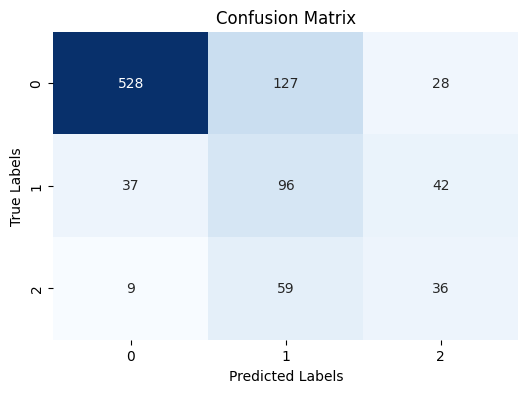


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 528/683 (77.31%)
Class 1: Correct Predictions / Total True Samples = 96/175 (54.86%)
Class 2: Correct Predictions / Total True Samples = 36/104 (34.62%)

Precision-Recall Curves:


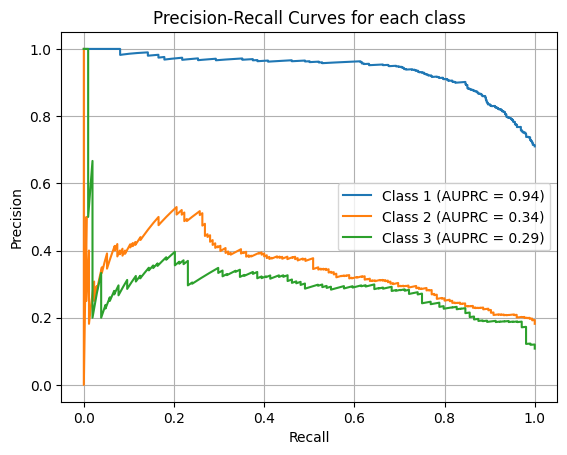


ROC Curves:


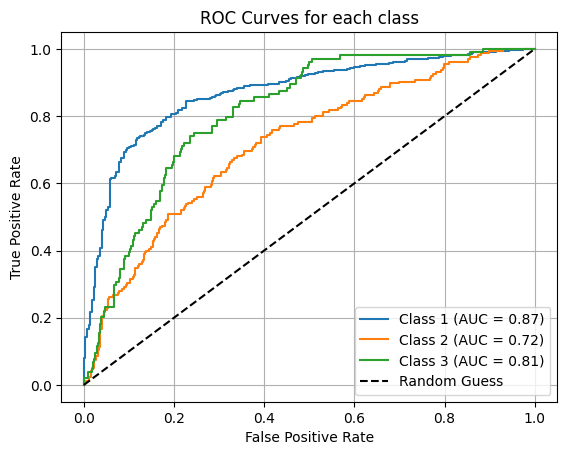


Mean F1 Score: 0.5344
Balanced Accuracy: 0.5559
Average AUPRC: 0.5248

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.77      0.84       683
           1       0.34      0.55      0.42       175
           2       0.34      0.35      0.34       104

    accuracy                           0.69       962
   macro avg       0.53      0.56      0.53       962
weighted avg       0.75      0.69      0.71       962

Fold No: 2
Epoch [1/100], Loss: 1.0984, Accuracy: 0.3458
Validation Loss: 1.0933, Validation Accuracy: 0.4418
Epoch [2/100], Loss: 1.0765, Accuracy: 0.4517
Validation Loss: 1.0411, Validation Accuracy: 0.5577
Epoch [3/100], Loss: 1.0268, Accuracy: 0.5241
Validation Loss: 0.9744, Validation Accuracy: 0.5609
Epoch [4/100], Loss: 1.0332, Accuracy: 0.5358
Validation Loss: 1.0152, Validation Accuracy: 0.5538
Epoch [5/100], Loss: 1.0203, Accuracy: 0.5740
Validation Loss: 0.9315, Validation Accuracy: 0.4788
Epoch [6/100], Los

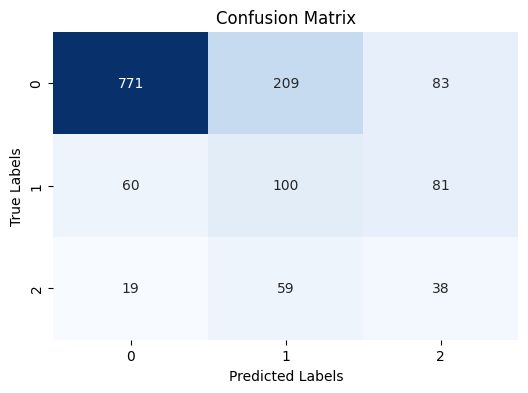


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 771/1063 (72.53%)
Class 1: Correct Predictions / Total True Samples = 100/241 (41.49%)
Class 2: Correct Predictions / Total True Samples = 38/116 (32.76%)

Precision-Recall Curves:


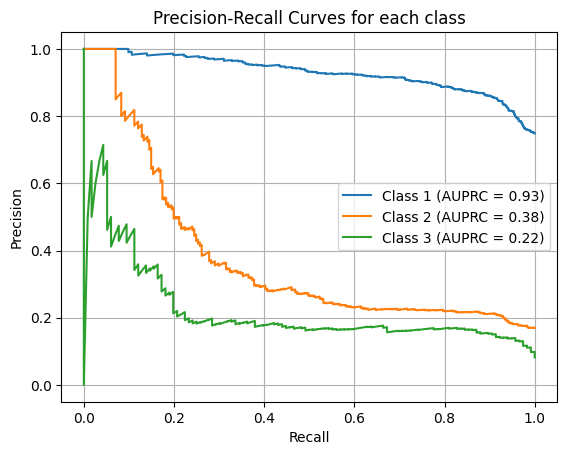


ROC Curves:


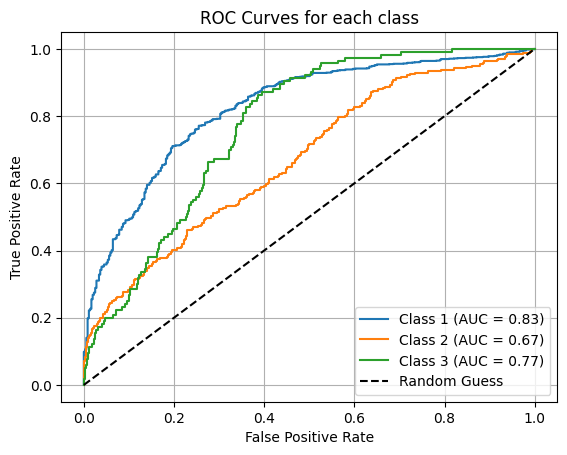


Mean F1 Score: 0.4578
Balanced Accuracy: 0.4893
Average AUPRC: 0.5081

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1063
           1       0.27      0.41      0.33       241
           2       0.19      0.33      0.24       116

    accuracy                           0.64      1420
   macro avg       0.46      0.49      0.46      1420
weighted avg       0.74      0.64      0.68      1420

Fold No: 3
Epoch [1/100], Loss: 1.0960, Accuracy: 0.3614
Validation Loss: 1.0936, Validation Accuracy: 0.3413
Epoch [2/100], Loss: 1.0657, Accuracy: 0.4689
Validation Loss: 1.0419, Validation Accuracy: 0.4021
Epoch [3/100], Loss: 1.0426, Accuracy: 0.5152
Validation Loss: 1.0698, Validation Accuracy: 0.4922
Epoch [4/100], Loss: 1.0289, Accuracy: 0.5545
Validation Loss: 1.0014, Validation Accuracy: 0.4515
Epoch [5/100], Loss: 1.0296, Accuracy: 0.5485
Validation Loss: 0.9828, Validation Accuracy: 0.4933
Epoch [6/100], Los

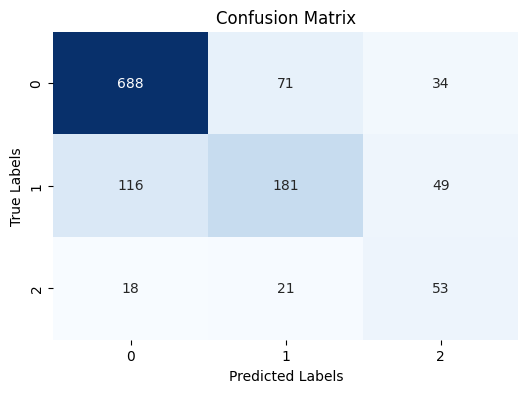


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 688/793 (86.76%)
Class 1: Correct Predictions / Total True Samples = 181/346 (52.31%)
Class 2: Correct Predictions / Total True Samples = 53/92 (57.61%)

Precision-Recall Curves:


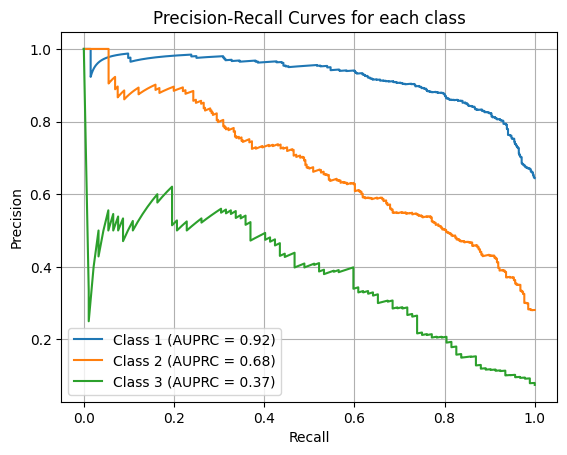


ROC Curves:


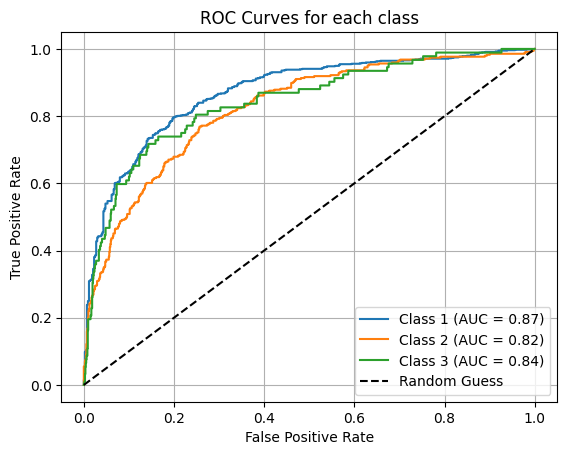


Mean F1 Score: 0.6339
Balanced Accuracy: 0.6556
Average AUPRC: 0.6571

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       793
           1       0.66      0.52      0.58       346
           2       0.39      0.58      0.46        92

    accuracy                           0.75      1231
   macro avg       0.63      0.66      0.63      1231
weighted avg       0.75      0.75      0.75      1231

Fold No: 4
Epoch [1/100], Loss: 1.0987, Accuracy: 0.3361
Validation Loss: 1.0979, Validation Accuracy: 0.3328
Epoch [2/100], Loss: 1.0932, Accuracy: 0.3953
Validation Loss: 1.0810, Validation Accuracy: 0.4765
Epoch [3/100], Loss: 1.0646, Accuracy: 0.4636
Validation Loss: 0.9991, Validation Accuracy: 0.4238
Epoch [4/100], Loss: 1.0539, Accuracy: 0.4827
Validation Loss: 1.0269, Validation Accuracy: 0.5191
Epoch [5/100], Loss: 1.0370, Accuracy: 0.5346
Validation Loss: 1.0055, Validation Accuracy: 0.5121
Epoch [6/100], Los

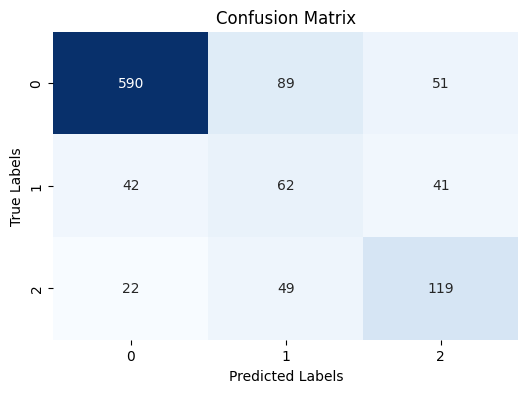


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 590/730 (80.82%)
Class 1: Correct Predictions / Total True Samples = 62/145 (42.76%)
Class 2: Correct Predictions / Total True Samples = 119/190 (62.63%)

Precision-Recall Curves:


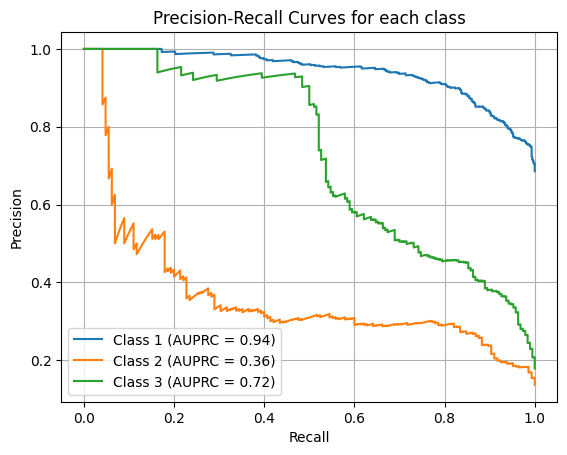


ROC Curves:


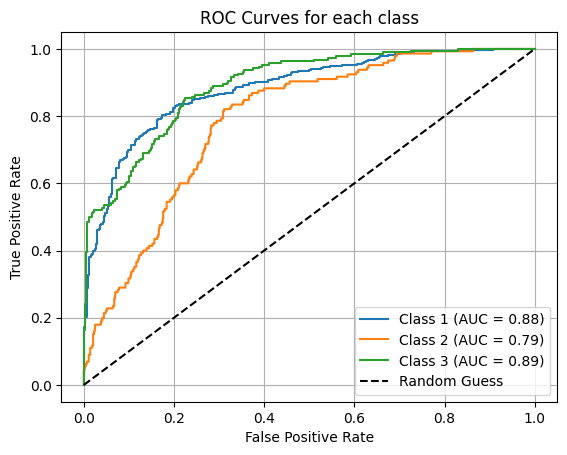


Mean F1 Score: 0.6018
Balanced Accuracy: 0.6207
Average AUPRC: 0.6768

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.81      0.85       730
           1       0.31      0.43      0.36       145
           2       0.56      0.63      0.59       190

    accuracy                           0.72      1065
   macro avg       0.59      0.62      0.60      1065
weighted avg       0.76      0.72      0.74      1065

Fold No: 5
Epoch [1/100], Loss: 1.0989, Accuracy: 0.3098
Validation Loss: 1.0997, Validation Accuracy: 0.4010
Epoch [2/100], Loss: 1.0941, Accuracy: 0.3889
Validation Loss: 1.0299, Validation Accuracy: 0.4770
Epoch [3/100], Loss: 1.0606, Accuracy: 0.4776
Validation Loss: 1.0723, Validation Accuracy: 0.4856
Epoch [4/100], Loss: 1.0604, Accuracy: 0.4915
Validation Loss: 0.9584, Validation Accuracy: 0.5679
Epoch [5/100], Loss: 1.0378, Accuracy: 0.5256
Validation Loss: 0.9651, Validation Accuracy: 0.5765
Epoch [6/100], Los

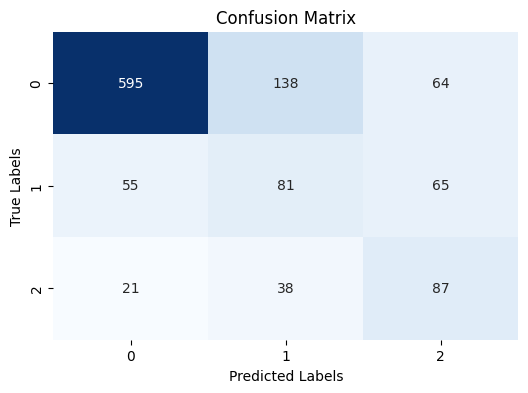


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 595/797 (74.65%)
Class 1: Correct Predictions / Total True Samples = 81/201 (40.30%)
Class 2: Correct Predictions / Total True Samples = 87/146 (59.59%)

Precision-Recall Curves:


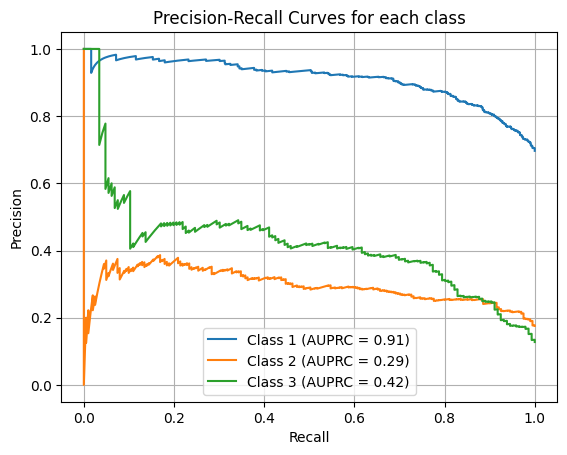


ROC Curves:


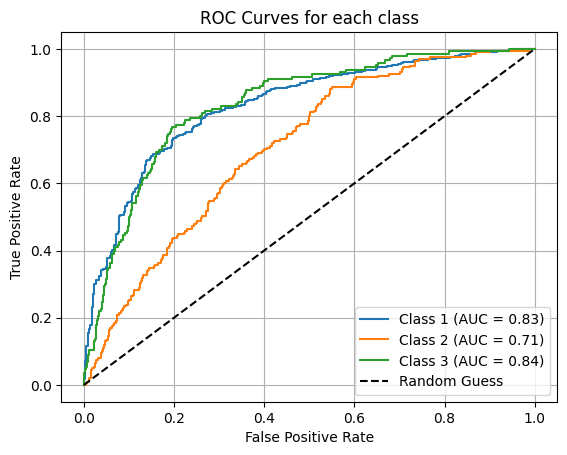


Mean F1 Score: 0.5483
Balanced Accuracy: 0.5818
Average AUPRC: 0.5413

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.75      0.81       797
           1       0.32      0.40      0.35       201
           2       0.40      0.60      0.48       146

    accuracy                           0.67      1144
   macro avg       0.53      0.58      0.55      1144
weighted avg       0.72      0.67      0.69      1144


RESULTS FOR PARAMETER SET 1
Accuracy for each fold: ['0.5559', '0.4893', '0.6556', '0.6207', '0.5818']
Average Accuracy: 0.5807
AUPRC for each fold: ['0.5248', '0.5081', '0.6571', '0.6768', '0.5413']
Average AUPRC: 0.5816
Best fold class-wise balanced accuracy: ['0.7431', '0.4132', '0.4220']


RUNNING PARAMETER SET 2/5
Parameters: {'hidden_size': 256, 'num_layers': 4, 'learning_rate': 0.00046037658937661427, 'weight_decay': 8.389509863697752e-06, 'batch_size': 32, 'dropout': 0.3, 'label_smoothing': 0.3, 'factor': 1, '

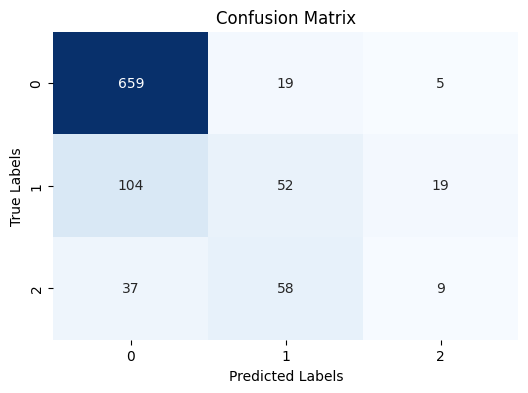


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 659/683 (96.49%)
Class 1: Correct Predictions / Total True Samples = 52/175 (29.71%)
Class 2: Correct Predictions / Total True Samples = 9/104 (8.65%)

Precision-Recall Curves:


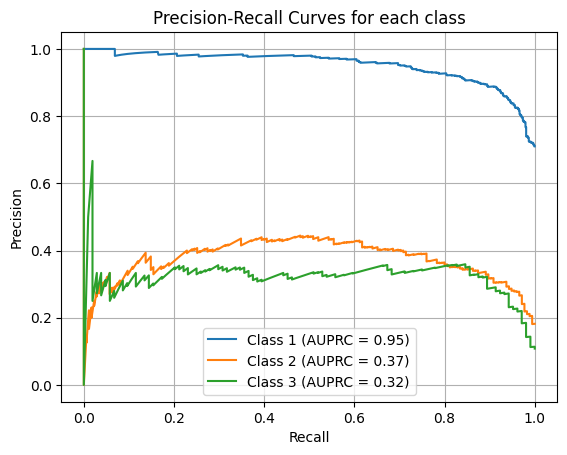


ROC Curves:


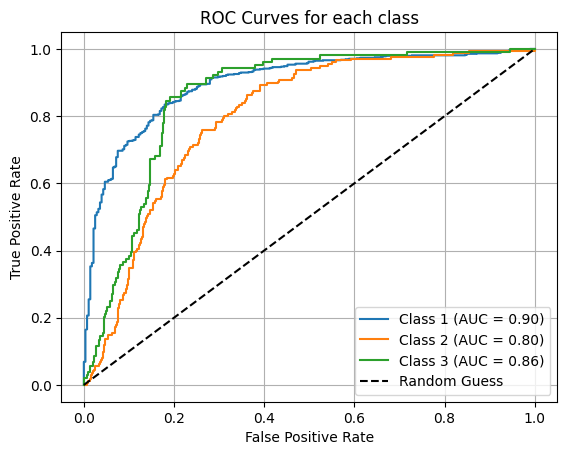


Mean F1 Score: 0.4541
Balanced Accuracy: 0.4495
Average AUPRC: 0.5484

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.89       683
           1       0.40      0.30      0.34       175
           2       0.27      0.09      0.13       104

    accuracy                           0.75       962
   macro avg       0.50      0.45      0.45       962
weighted avg       0.69      0.75      0.71       962

Fold No: 2
Epoch [1/100], Loss: 1.0676, Accuracy: 0.4564
Validation Loss: 1.1094, Validation Accuracy: 0.4477
Epoch [2/100], Loss: 1.0491, Accuracy: 0.4860
Validation Loss: 1.0207, Validation Accuracy: 0.3748
Epoch [3/100], Loss: 1.0263, Accuracy: 0.5312
Validation Loss: 0.9442, Validation Accuracy: 0.4691
Epoch [4/100], Loss: 1.0202, Accuracy: 0.5506
Validation Loss: 1.0744, Validation Accuracy: 0.4740
Epoch [5/100], Loss: 1.0258, Accuracy: 0.5413
Validation Loss: 1.0070, Validation Accuracy: 0.5919
Epoch [6/100], Los

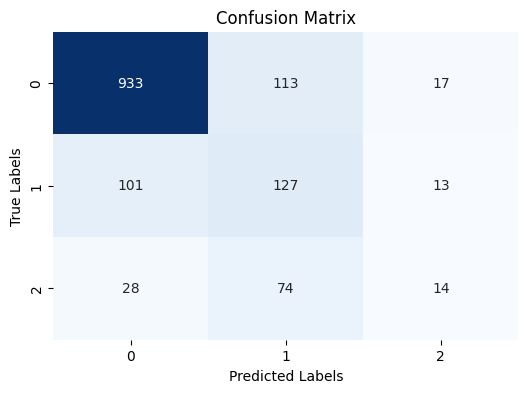


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 933/1063 (87.77%)
Class 1: Correct Predictions / Total True Samples = 127/241 (52.70%)
Class 2: Correct Predictions / Total True Samples = 14/116 (12.07%)

Precision-Recall Curves:


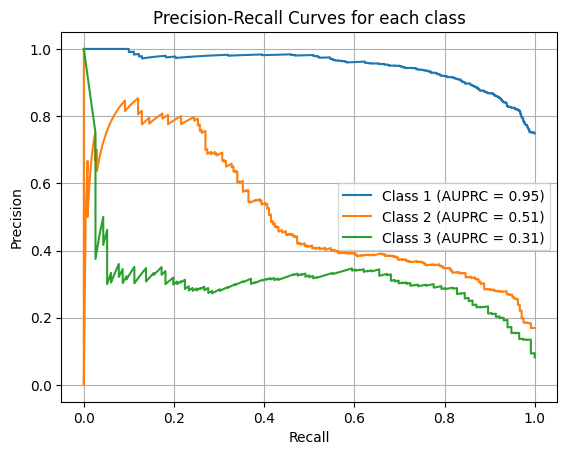


ROC Curves:


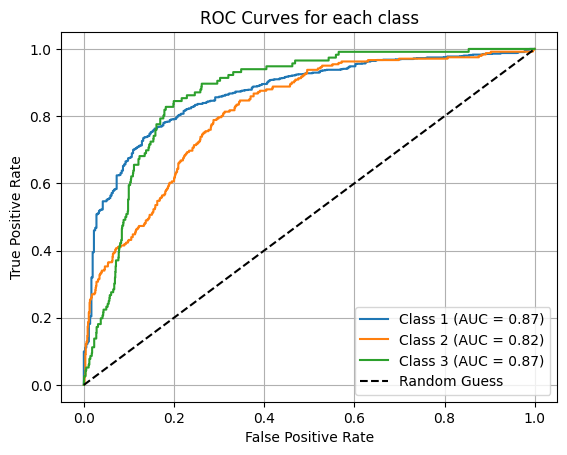


Mean F1 Score: 0.5036
Balanced Accuracy: 0.5085
Average AUPRC: 0.5889

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1063
           1       0.40      0.53      0.46       241
           2       0.32      0.12      0.17       116

    accuracy                           0.76      1420
   macro avg       0.53      0.51      0.50      1420
weighted avg       0.75      0.76      0.75      1420

Fold No: 3
Epoch [1/100], Loss: 1.0809, Accuracy: 0.3992
Validation Loss: 0.9551, Validation Accuracy: 0.3789
Epoch [2/100], Loss: 1.0346, Accuracy: 0.5326
Validation Loss: 1.0081, Validation Accuracy: 0.4979
Epoch [3/100], Loss: 1.0248, Accuracy: 0.5689
Validation Loss: 0.9232, Validation Accuracy: 0.3604
Epoch [4/100], Loss: 1.0115, Accuracy: 0.5894
Validation Loss: 0.9280, Validation Accuracy: 0.4246
Epoch [5/100], Loss: 1.0233, Accuracy: 0.5568
Validation Loss: 1.0112, Validation Accuracy: 0.4594
Epoch [6/100], Los

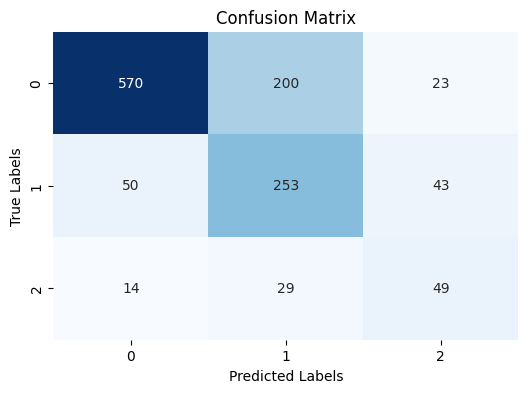


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 570/793 (71.88%)
Class 1: Correct Predictions / Total True Samples = 253/346 (73.12%)
Class 2: Correct Predictions / Total True Samples = 49/92 (53.26%)

Precision-Recall Curves:


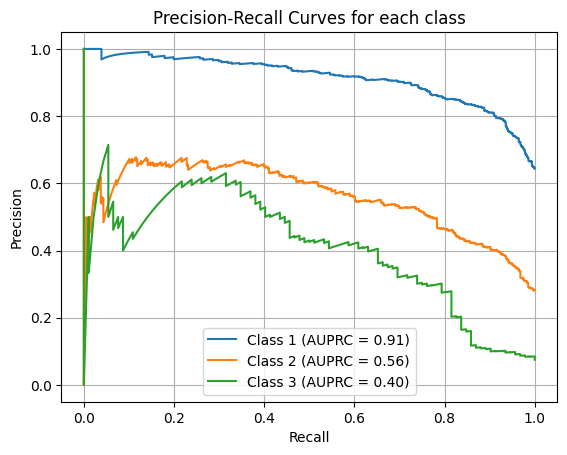


ROC Curves:


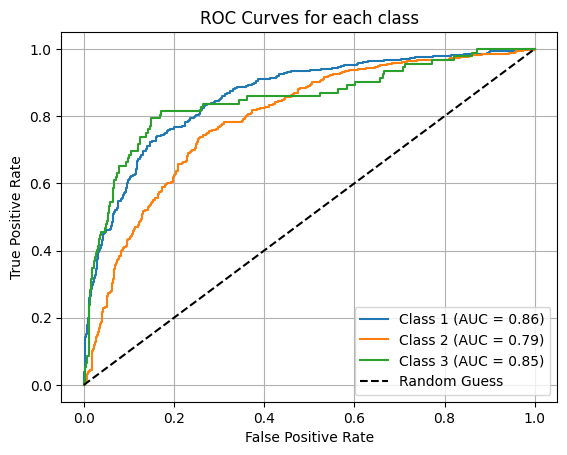


Mean F1 Score: 0.6278
Balanced Accuracy: 0.6609
Average AUPRC: 0.6244

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80       793
           1       0.52      0.73      0.61       346
           2       0.43      0.53      0.47        92

    accuracy                           0.71      1231
   macro avg       0.62      0.66      0.63      1231
weighted avg       0.76      0.71      0.72      1231

Fold No: 4
Epoch [1/100], Loss: 1.0998, Accuracy: 0.3352
Validation Loss: 1.1136, Validation Accuracy: 0.3337
Epoch [2/100], Loss: 1.0753, Accuracy: 0.4281
Validation Loss: 1.0690, Validation Accuracy: 0.4569
Epoch [3/100], Loss: 1.0560, Accuracy: 0.4891
Validation Loss: 0.9871, Validation Accuracy: 0.5203
Epoch [4/100], Loss: 1.0482, Accuracy: 0.4699
Validation Loss: 0.9949, Validation Accuracy: 0.4930
Epoch [5/100], Loss: 1.0285, Accuracy: 0.5128
Validation Loss: 0.9661, Validation Accuracy: 0.5556
Epoch [6/100], Los

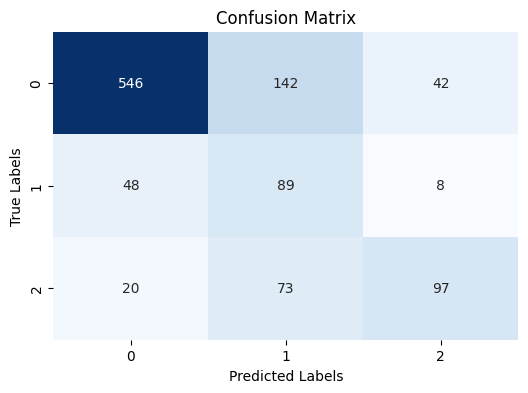


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 546/730 (74.79%)
Class 1: Correct Predictions / Total True Samples = 89/145 (61.38%)
Class 2: Correct Predictions / Total True Samples = 97/190 (51.05%)

Precision-Recall Curves:


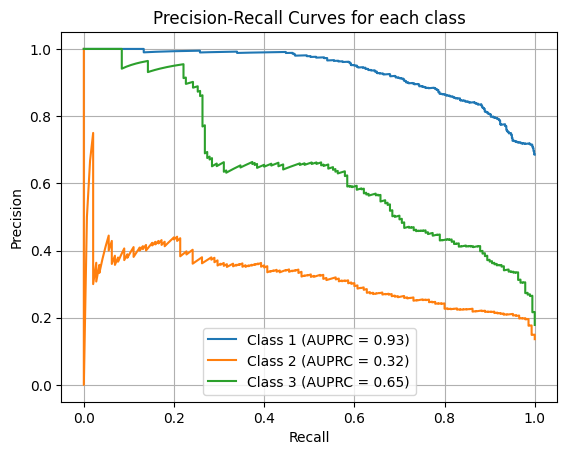


ROC Curves:


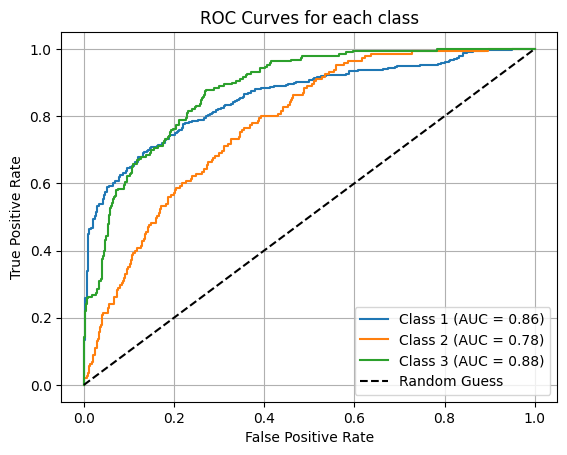


Mean F1 Score: 0.5949
Balanced Accuracy: 0.6241
Average AUPRC: 0.6321

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.75      0.81       730
           1       0.29      0.61      0.40       145
           2       0.66      0.51      0.58       190

    accuracy                           0.69      1065
   macro avg       0.61      0.62      0.59      1065
weighted avg       0.77      0.69      0.71      1065

Fold No: 5
Epoch [1/100], Loss: 1.0991, Accuracy: 0.3397
Validation Loss: 1.1278, Validation Accuracy: 0.3388
Epoch [2/100], Loss: 1.0963, Accuracy: 0.4295
Validation Loss: 0.9520, Validation Accuracy: 0.3644
Epoch [3/100], Loss: 1.1108, Accuracy: 0.3558
Validation Loss: 1.0926, Validation Accuracy: 0.3886
Epoch [4/100], Loss: 1.0943, Accuracy: 0.4209
Validation Loss: 1.0007, Validation Accuracy: 0.4835
Epoch [5/100], Loss: 1.0602, Accuracy: 0.4808
Validation Loss: 1.1158, Validation Accuracy: 0.4262
Epoch [6/100], Los

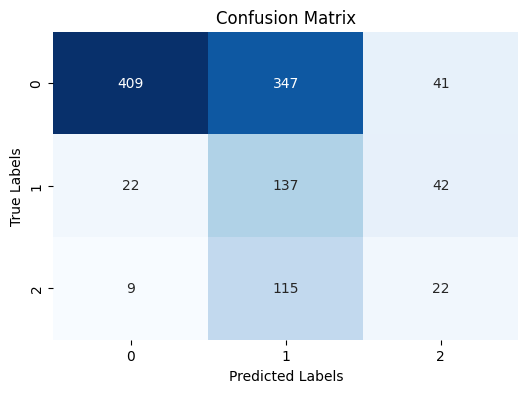


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 409/797 (51.32%)
Class 1: Correct Predictions / Total True Samples = 137/201 (68.16%)
Class 2: Correct Predictions / Total True Samples = 22/146 (15.07%)

Precision-Recall Curves:


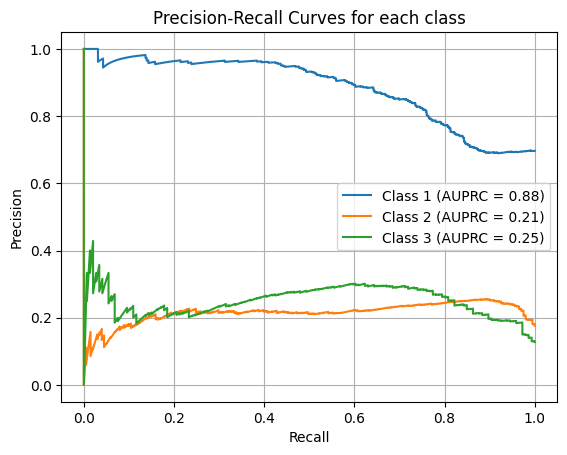


ROC Curves:


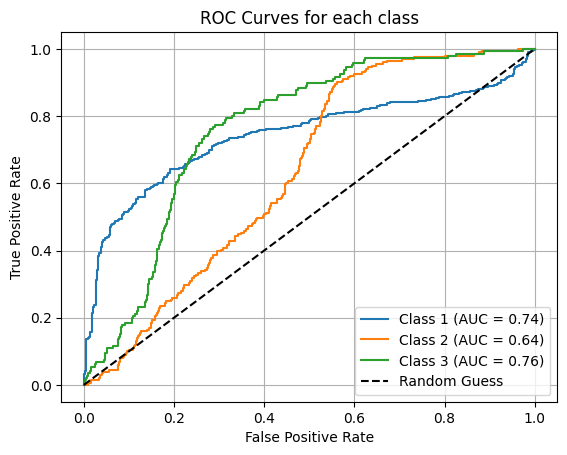


Mean F1 Score: 0.3930
Balanced Accuracy: 0.4485
Average AUPRC: 0.4491

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.51      0.66       797
           1       0.23      0.68      0.34       201
           2       0.21      0.15      0.18       146

    accuracy                           0.50      1144
   macro avg       0.46      0.45      0.39      1144
weighted avg       0.71      0.50      0.54      1144


RESULTS FOR PARAMETER SET 2
Accuracy for each fold: ['0.4495', '0.5085', '0.6609', '0.6241', '0.4485']
Average Accuracy: 0.5383
AUPRC for each fold: ['0.5484', '0.5889', '0.6244', '0.6321', '0.4491']
Average AUPRC: 0.5686
Best fold class-wise balanced accuracy: ['0.7998', '0.4400', '0.4042']


RUNNING PARAMETER SET 3/5
Parameters: {'hidden_size': 256, 'num_layers': 4, 'learning_rate': 0.00020601678097967096, 'weight_decay': 1.4147278204236746e-05, 'batch_size': 32, 'dropout': 0.2, 'label_smoothing': 0.3, 'factor': 1, 

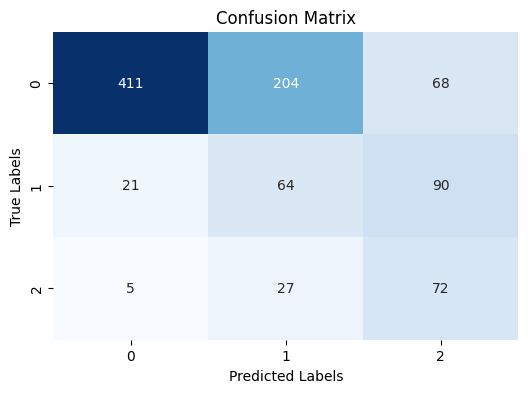


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 411/683 (60.18%)
Class 1: Correct Predictions / Total True Samples = 64/175 (36.57%)
Class 2: Correct Predictions / Total True Samples = 72/104 (69.23%)

Precision-Recall Curves:


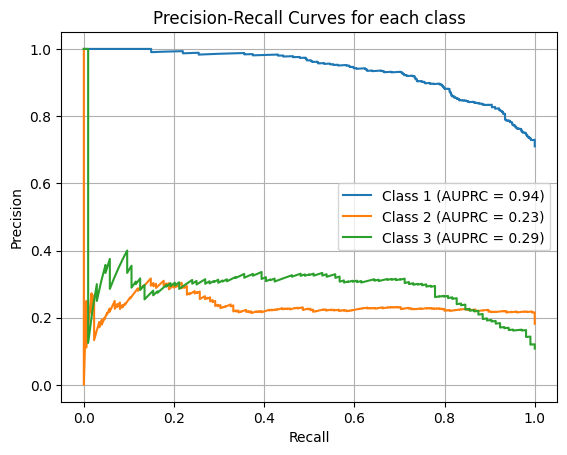


ROC Curves:


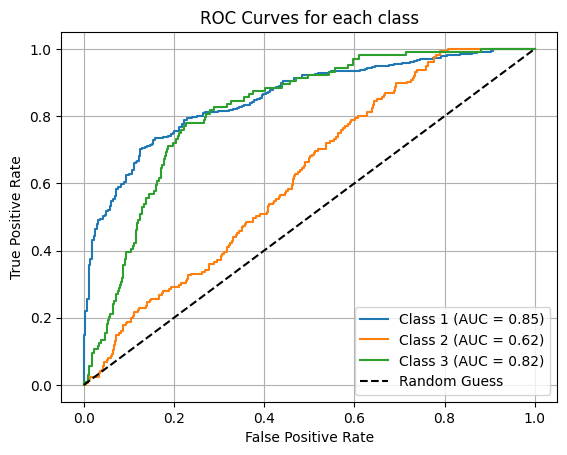


Mean F1 Score: 0.4791
Balanced Accuracy: 0.5533
Average AUPRC: 0.4881

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.60      0.73       683
           1       0.22      0.37      0.27       175
           2       0.31      0.69      0.43       104

    accuracy                           0.57       962
   macro avg       0.49      0.55      0.48       962
weighted avg       0.74      0.57      0.62       962

Fold No: 2
Epoch [1/100], Loss: 1.0896, Accuracy: 0.3816
Validation Loss: 1.0084, Validation Accuracy: 0.3739
Epoch [2/100], Loss: 1.0306, Accuracy: 0.5421
Validation Loss: 1.0696, Validation Accuracy: 0.4972
Epoch [3/100], Loss: 1.0030, Accuracy: 0.5888
Validation Loss: 1.0600, Validation Accuracy: 0.5291
Epoch [4/100], Loss: 0.9994, Accuracy: 0.6114
Validation Loss: 0.9235, Validation Accuracy: 0.4547
Epoch [5/100], Loss: 1.0188, Accuracy: 0.5896
Validation Loss: 1.0845, Validation Accuracy: 0.5087
Epoch [6/100], Los

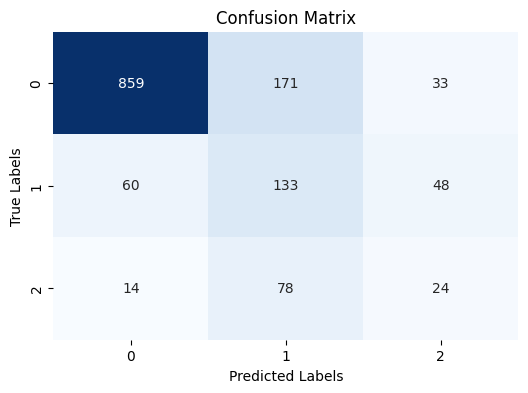


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 859/1063 (80.81%)
Class 1: Correct Predictions / Total True Samples = 133/241 (55.19%)
Class 2: Correct Predictions / Total True Samples = 24/116 (20.69%)

Precision-Recall Curves:


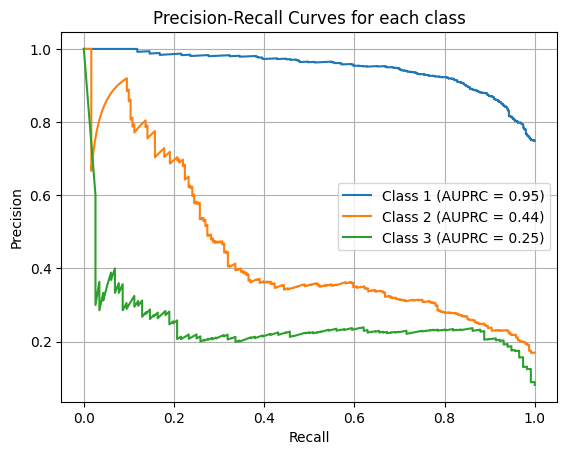


ROC Curves:


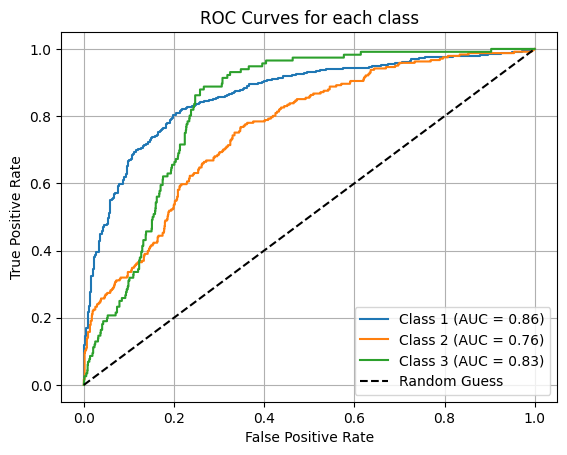


Mean F1 Score: 0.5016
Balanced Accuracy: 0.5223
Average AUPRC: 0.5464

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      1063
           1       0.35      0.55      0.43       241
           2       0.23      0.21      0.22       116

    accuracy                           0.72      1420
   macro avg       0.50      0.52      0.50      1420
weighted avg       0.77      0.72      0.73      1420

Fold No: 3
Epoch [1/100], Loss: 1.0835, Accuracy: 0.4083
Validation Loss: 0.9129, Validation Accuracy: 0.4679
Epoch [2/100], Loss: 1.0291, Accuracy: 0.5455
Validation Loss: 1.0102, Validation Accuracy: 0.5038
Epoch [3/100], Loss: 1.0054, Accuracy: 0.5864
Validation Loss: 0.9306, Validation Accuracy: 0.4880
Epoch [4/100], Loss: 1.0028, Accuracy: 0.5811
Validation Loss: 0.9301, Validation Accuracy: 0.4593
Epoch [5/100], Loss: 0.9899, Accuracy: 0.6235
Validation Loss: 0.9240, Validation Accuracy: 0.4719
Epoch [6/100], Los

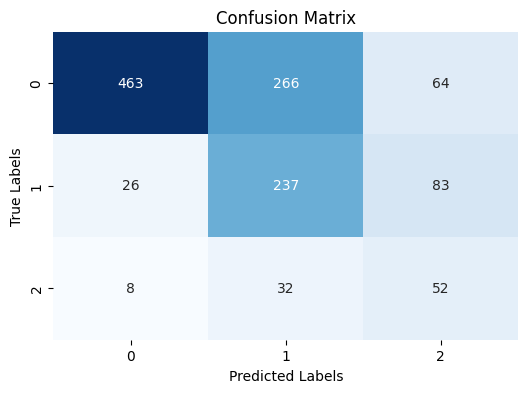


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 463/793 (58.39%)
Class 1: Correct Predictions / Total True Samples = 237/346 (68.50%)
Class 2: Correct Predictions / Total True Samples = 52/92 (56.52%)

Precision-Recall Curves:


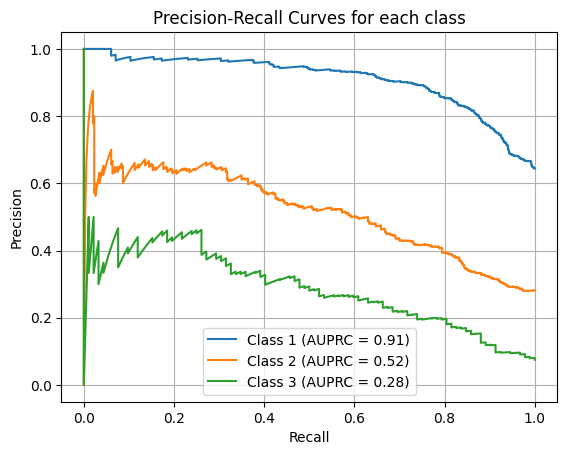


ROC Curves:


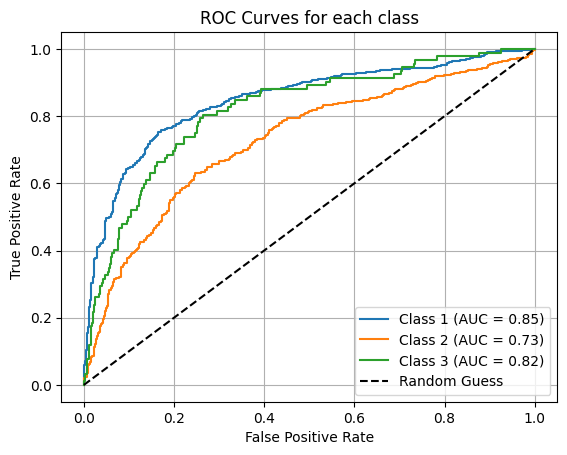


Mean F1 Score: 0.5377
Balanced Accuracy: 0.6113
Average AUPRC: 0.5701

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.58      0.72       793
           1       0.44      0.68      0.54       346
           2       0.26      0.57      0.36        92

    accuracy                           0.61      1231
   macro avg       0.55      0.61      0.54      1231
weighted avg       0.74      0.61      0.64      1231

Fold No: 4
Epoch [1/100], Loss: 1.0964, Accuracy: 0.3506
Validation Loss: 1.0669, Validation Accuracy: 0.4759
Epoch [2/100], Loss: 1.0570, Accuracy: 0.4991
Validation Loss: 1.0129, Validation Accuracy: 0.4965
Epoch [3/100], Loss: 1.0340, Accuracy: 0.5091
Validation Loss: 0.9833, Validation Accuracy: 0.5455
Epoch [4/100], Loss: 1.0302, Accuracy: 0.5373
Validation Loss: 1.0043, Validation Accuracy: 0.5626
Epoch [5/100], Loss: 1.0188, Accuracy: 0.5546
Validation Loss: 1.0844, Validation Accuracy: 0.5289
Epoch [6/100], Los

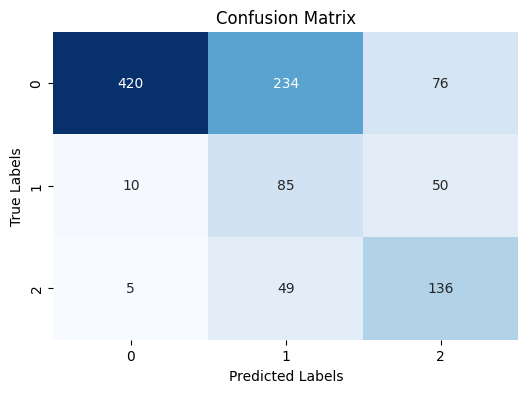


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 420/730 (57.53%)
Class 1: Correct Predictions / Total True Samples = 85/145 (58.62%)
Class 2: Correct Predictions / Total True Samples = 136/190 (71.58%)

Precision-Recall Curves:


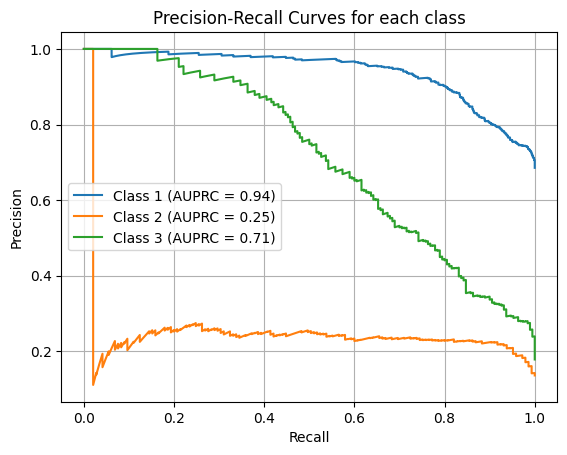


ROC Curves:


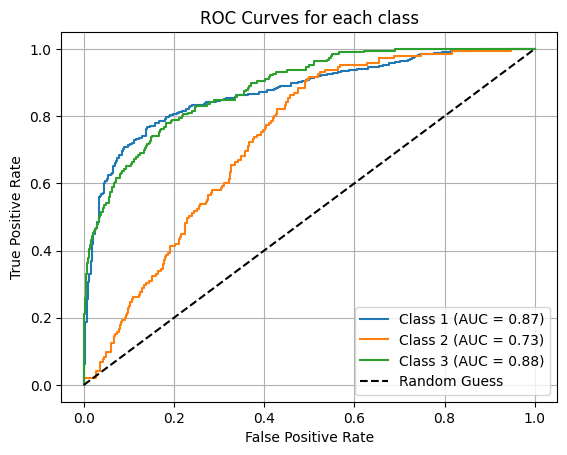


Mean F1 Score: 0.5514
Balanced Accuracy: 0.6258
Average AUPRC: 0.6331

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.58      0.72       730
           1       0.23      0.59      0.33       145
           2       0.52      0.72      0.60       190

    accuracy                           0.60      1065
   macro avg       0.57      0.63      0.55      1065
weighted avg       0.79      0.60      0.65      1065

Fold No: 5
Epoch [1/100], Loss: 1.0970, Accuracy: 0.3568
Validation Loss: 1.0461, Validation Accuracy: 0.5207
Epoch [2/100], Loss: 1.0586, Accuracy: 0.4733
Validation Loss: 1.0081, Validation Accuracy: 0.5503
Epoch [3/100], Loss: 1.0340, Accuracy: 0.5224
Validation Loss: 0.9425, Validation Accuracy: 0.6089
Epoch [4/100], Loss: 1.0262, Accuracy: 0.5481
Validation Loss: 0.9943, Validation Accuracy: 0.6034
Epoch [5/100], Loss: 1.0240, Accuracy: 0.5662
Validation Loss: 1.0482, Validation Accuracy: 0.5222
Epoch [6/100], Los

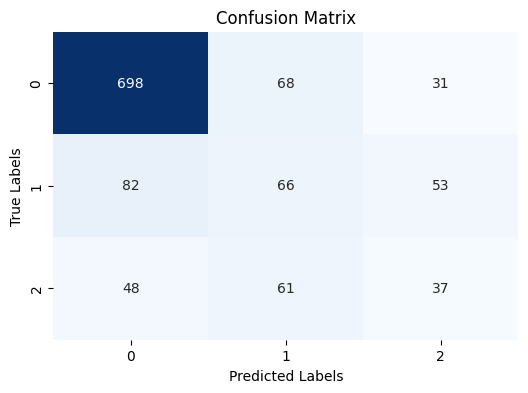


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 698/797 (87.58%)
Class 1: Correct Predictions / Total True Samples = 66/201 (32.84%)
Class 2: Correct Predictions / Total True Samples = 37/146 (25.34%)

Precision-Recall Curves:


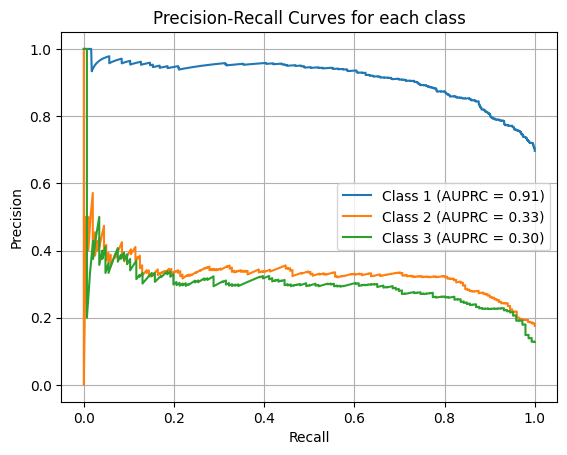


ROC Curves:


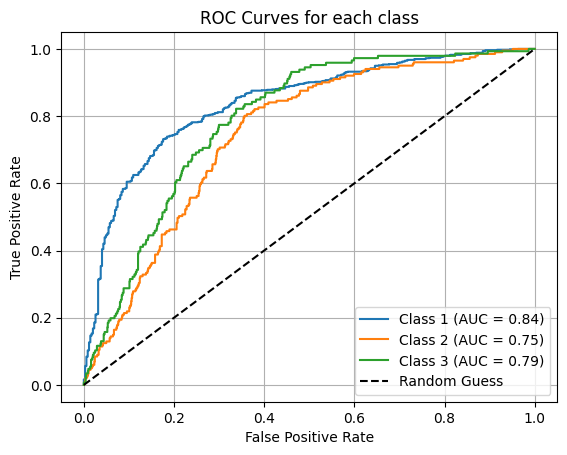


Mean F1 Score: 0.4899
Balanced Accuracy: 0.4859
Average AUPRC: 0.5124

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       797
           1       0.34      0.33      0.33       201
           2       0.31      0.25      0.28       146

    accuracy                           0.70      1144
   macro avg       0.50      0.49      0.49      1144
weighted avg       0.69      0.70      0.69      1144


RESULTS FOR PARAMETER SET 3
Accuracy for each fold: ['0.5533', '0.5223', '0.6113', '0.6258', '0.4859']
Average Accuracy: 0.5597
AUPRC for each fold: ['0.4881', '0.5464', '0.5701', '0.6331', '0.5124']
Average AUPRC: 0.5500
Best fold class-wise balanced accuracy: ['0.7555', '0.3680', '0.4304']


RUNNING PARAMETER SET 4/5
Parameters: {'hidden_size': 256, 'num_layers': 4, 'learning_rate': 0.00010881956338415986, 'weight_decay': 7.962304579713443e-06, 'batch_size': 32, 'dropout': 0.2, 'label_smoothing': 0.3, 'factor': 1, '

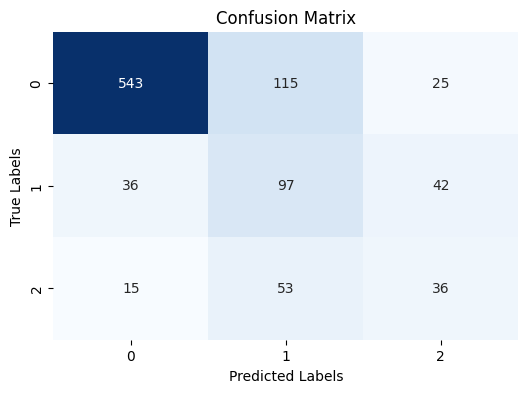


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 543/683 (79.50%)
Class 1: Correct Predictions / Total True Samples = 97/175 (55.43%)
Class 2: Correct Predictions / Total True Samples = 36/104 (34.62%)

Precision-Recall Curves:


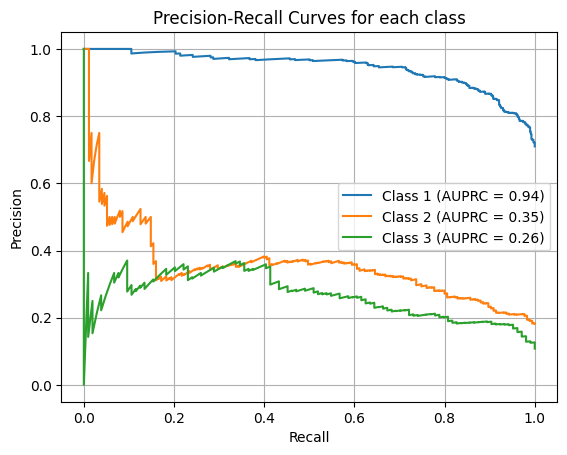


ROC Curves:


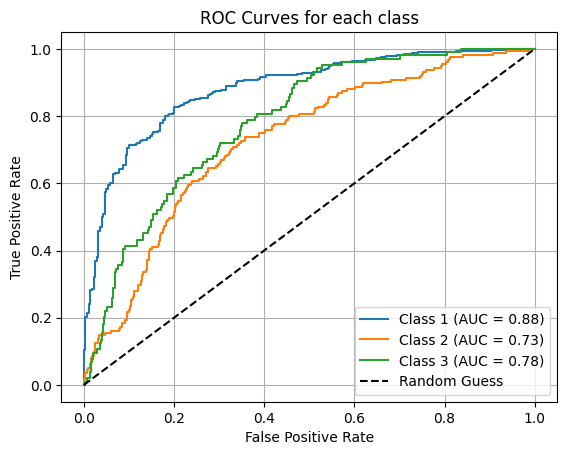


Mean F1 Score: 0.5464
Balanced Accuracy: 0.5652
Average AUPRC: 0.5209

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.80      0.85       683
           1       0.37      0.55      0.44       175
           2       0.35      0.35      0.35       104

    accuracy                           0.70       962
   macro avg       0.54      0.57      0.55       962
weighted avg       0.75      0.70      0.72       962

Fold No: 2
Epoch [1/100], Loss: 1.0878, Accuracy: 0.3995
Validation Loss: 1.0461, Validation Accuracy: 0.5419
Epoch [2/100], Loss: 1.0276, Accuracy: 0.5428
Validation Loss: 1.0188, Validation Accuracy: 0.5377
Epoch [3/100], Loss: 0.9987, Accuracy: 0.5974
Validation Loss: 1.0387, Validation Accuracy: 0.5504
Epoch [4/100], Loss: 0.9857, Accuracy: 0.6207
Validation Loss: 0.9309, Validation Accuracy: 0.5239
Epoch [5/100], Loss: 0.9952, Accuracy: 0.6106
Validation Loss: 1.0160, Validation Accuracy: 0.5645
Epoch [6/100], Los

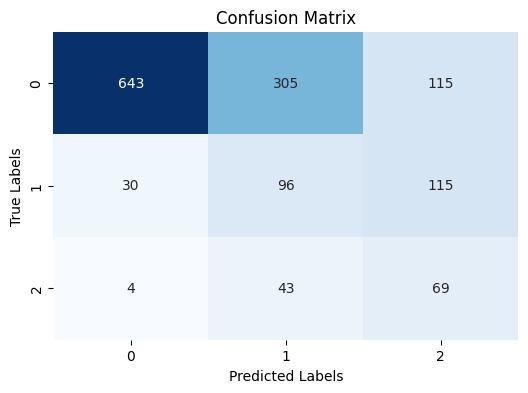


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 643/1063 (60.49%)
Class 1: Correct Predictions / Total True Samples = 96/241 (39.83%)
Class 2: Correct Predictions / Total True Samples = 69/116 (59.48%)

Precision-Recall Curves:


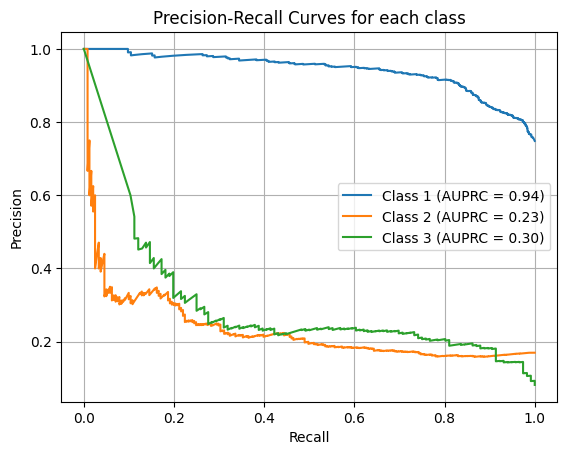


ROC Curves:


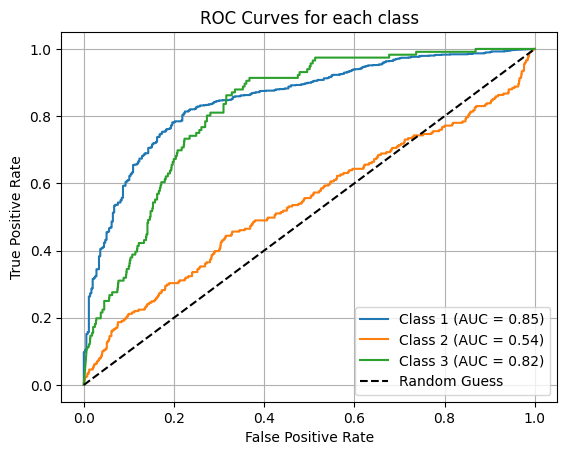


Mean F1 Score: 0.4506
Balanced Accuracy: 0.5327
Average AUPRC: 0.4924

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.60      0.74      1063
           1       0.22      0.40      0.28       241
           2       0.23      0.59      0.33       116

    accuracy                           0.57      1420
   macro avg       0.47      0.53      0.45      1420
weighted avg       0.77      0.57      0.63      1420

Fold No: 3
Epoch [1/100], Loss: 1.0871, Accuracy: 0.4098
Validation Loss: 0.9623, Validation Accuracy: 0.3834
Epoch [2/100], Loss: 1.0206, Accuracy: 0.5598
Validation Loss: 0.9882, Validation Accuracy: 0.4785
Epoch [3/100], Loss: 1.0142, Accuracy: 0.5811
Validation Loss: 1.0367, Validation Accuracy: 0.5199
Epoch [4/100], Loss: 1.0002, Accuracy: 0.5795
Validation Loss: 0.9332, Validation Accuracy: 0.5053
Epoch [5/100], Loss: 0.9960, Accuracy: 0.6061
Validation Loss: 0.9355, Validation Accuracy: 0.4911
Epoch [6/100], Los

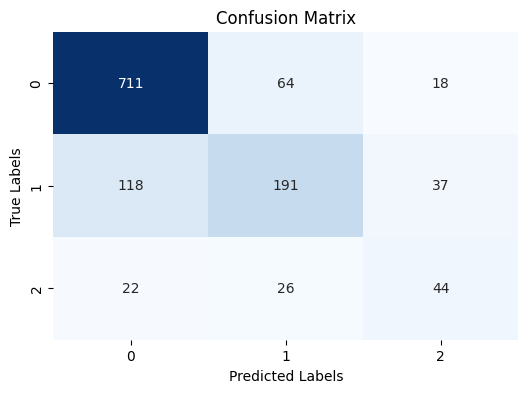


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 711/793 (89.66%)
Class 1: Correct Predictions / Total True Samples = 191/346 (55.20%)
Class 2: Correct Predictions / Total True Samples = 44/92 (47.83%)

Precision-Recall Curves:


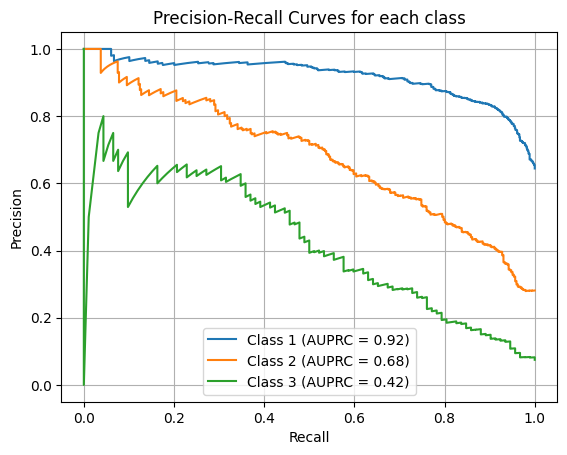


ROC Curves:


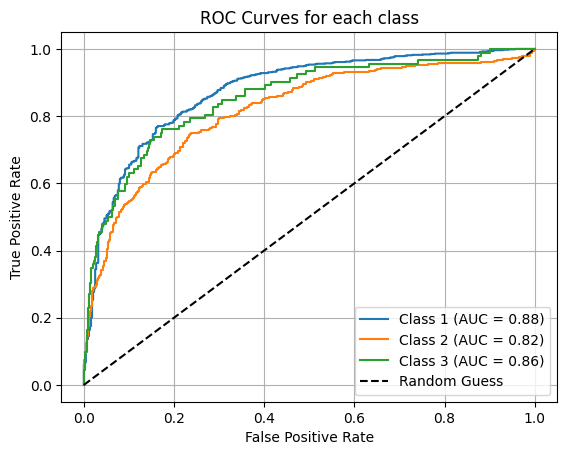


Mean F1 Score: 0.6450
Balanced Accuracy: 0.6423
Average AUPRC: 0.6720

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.86       793
           1       0.68      0.55      0.61       346
           2       0.44      0.48      0.46        92

    accuracy                           0.77      1231
   macro avg       0.65      0.64      0.64      1231
weighted avg       0.76      0.77      0.76      1231

Fold No: 4
Epoch [1/100], Loss: 1.0977, Accuracy: 0.3552
Validation Loss: 1.0918, Validation Accuracy: 0.4433
Epoch [2/100], Loss: 1.0610, Accuracy: 0.4863
Validation Loss: 1.0694, Validation Accuracy: 0.4722
Epoch [3/100], Loss: 1.0368, Accuracy: 0.5392
Validation Loss: 0.9823, Validation Accuracy: 0.5321
Epoch [4/100], Loss: 1.0314, Accuracy: 0.5510
Validation Loss: 0.9793, Validation Accuracy: 0.5689
Epoch [5/100], Loss: 1.0246, Accuracy: 0.5510
Validation Loss: 0.9989, Validation Accuracy: 0.5915
Epoch [6/100], Los

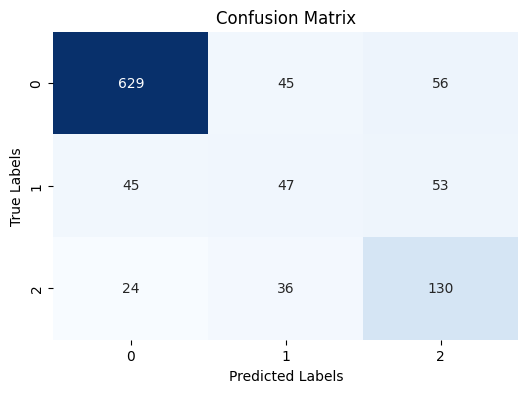


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 629/730 (86.16%)
Class 1: Correct Predictions / Total True Samples = 47/145 (32.41%)
Class 2: Correct Predictions / Total True Samples = 130/190 (68.42%)

Precision-Recall Curves:


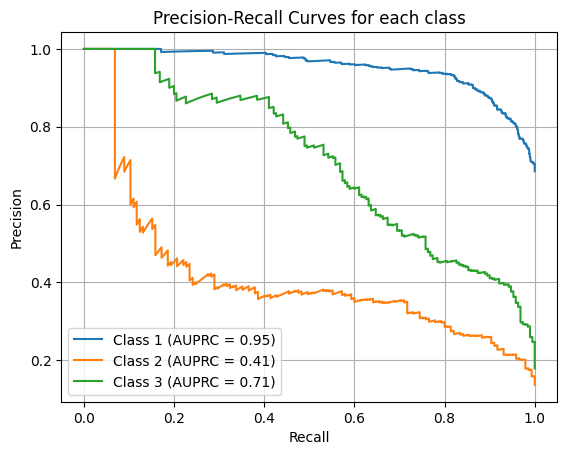


ROC Curves:


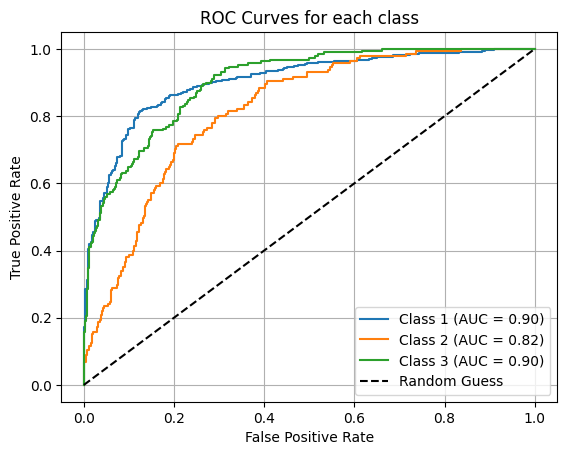


Mean F1 Score: 0.6104
Balanced Accuracy: 0.6233
Average AUPRC: 0.6919

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       730
           1       0.37      0.32      0.34       145
           2       0.54      0.68      0.61       190

    accuracy                           0.76      1065
   macro avg       0.60      0.62      0.61      1065
weighted avg       0.76      0.76      0.76      1065

Fold No: 5
Epoch [1/100], Loss: 1.0983, Accuracy: 0.3216
Validation Loss: 1.0895, Validation Accuracy: 0.4108
Epoch [2/100], Loss: 1.0835, Accuracy: 0.4113
Validation Loss: 1.0449, Validation Accuracy: 0.5223
Epoch [3/100], Loss: 1.0525, Accuracy: 0.4808
Validation Loss: 1.0323, Validation Accuracy: 0.5183
Epoch [4/100], Loss: 1.0297, Accuracy: 0.5459
Validation Loss: 0.9367, Validation Accuracy: 0.5823
Epoch [5/100], Loss: 1.0112, Accuracy: 0.5641
Validation Loss: 1.0338, Validation Accuracy: 0.5480
Epoch [6/100], Los

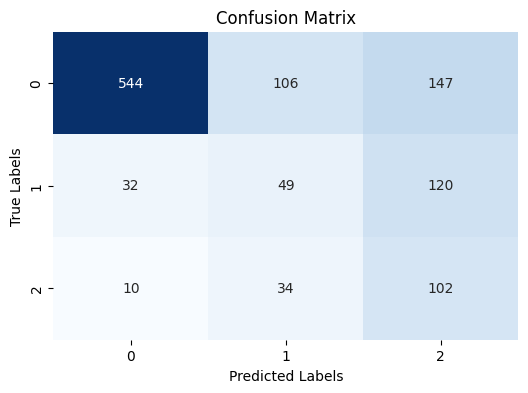


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 544/797 (68.26%)
Class 1: Correct Predictions / Total True Samples = 49/201 (24.38%)
Class 2: Correct Predictions / Total True Samples = 102/146 (69.86%)

Precision-Recall Curves:


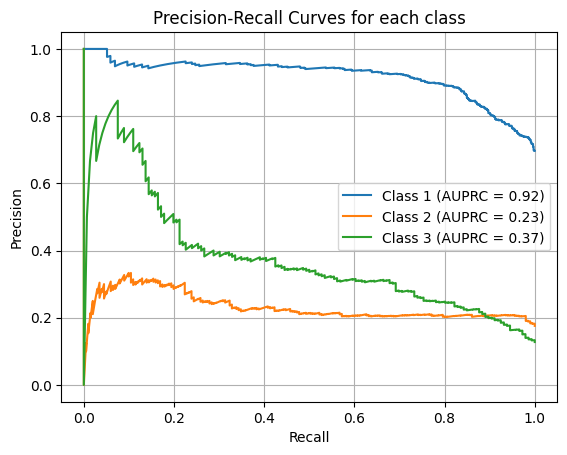


ROC Curves:


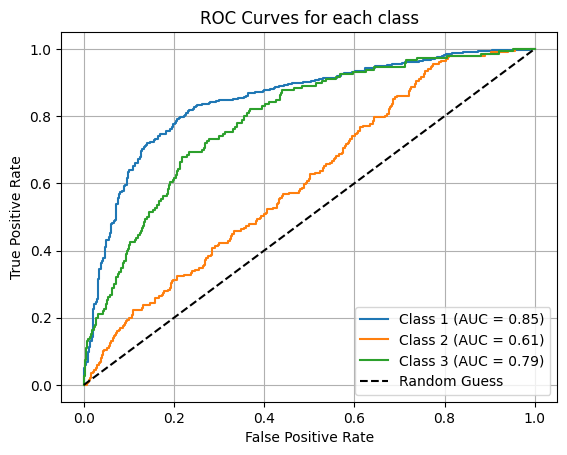


Mean F1 Score: 0.4780
Balanced Accuracy: 0.5417
Average AUPRC: 0.5085

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.68      0.79       797
           1       0.26      0.24      0.25       201
           2       0.28      0.70      0.40       146

    accuracy                           0.61      1144
   macro avg       0.49      0.54      0.48      1144
weighted avg       0.73      0.61      0.64      1144


RESULTS FOR PARAMETER SET 4
Accuracy for each fold: ['0.5652', '0.5327', '0.6423', '0.6233', '0.5417']
Average Accuracy: 0.5810
AUPRC for each fold: ['0.5209', '0.4924', '0.6720', '0.6919', '0.5085']
Average AUPRC: 0.5771
Best fold class-wise balanced accuracy: ['0.7872', '0.4381', '0.4348']


RUNNING PARAMETER SET 5/5
Parameters: {'hidden_size': 256, 'num_layers': 4, 'learning_rate': 0.0001667453140535747, 'weight_decay': 1.0022271626546467e-05, 'batch_size': 32, 'dropout': 0.2, 'label_smoothing': 0.3, 'factor': 1, '

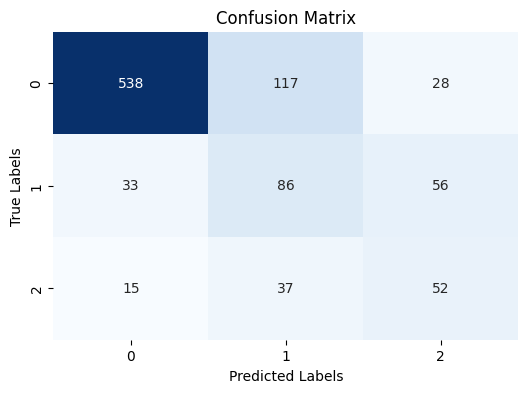


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 538/683 (78.77%)
Class 1: Correct Predictions / Total True Samples = 86/175 (49.14%)
Class 2: Correct Predictions / Total True Samples = 52/104 (50.00%)

Precision-Recall Curves:


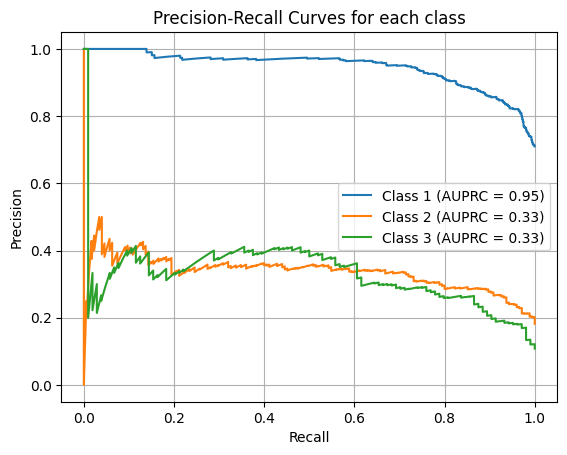


ROC Curves:


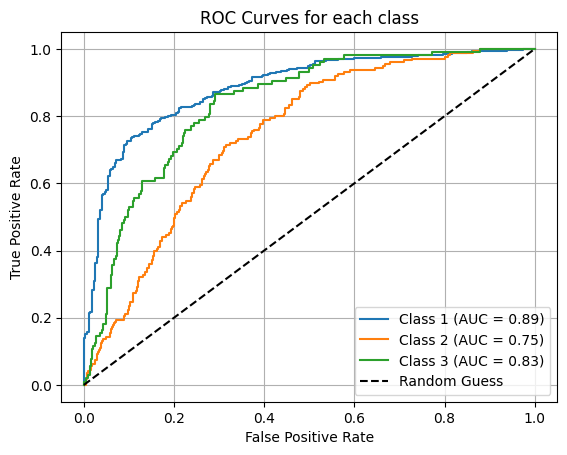


Mean F1 Score: 0.5652
Balanced Accuracy: 0.5930
Average AUPRC: 0.5359

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       683
           1       0.36      0.49      0.41       175
           2       0.38      0.50      0.43       104

    accuracy                           0.70       962
   macro avg       0.55      0.59      0.57       962
weighted avg       0.76      0.70      0.72       962

Fold No: 2
Epoch [1/100], Loss: 1.0787, Accuracy: 0.4213
Validation Loss: 1.1013, Validation Accuracy: 0.4725
Epoch [2/100], Loss: 1.0223, Accuracy: 0.5576
Validation Loss: 0.9779, Validation Accuracy: 0.5223
Epoch [3/100], Loss: 1.0157, Accuracy: 0.5802
Validation Loss: 1.0355, Validation Accuracy: 0.5489
Epoch [4/100], Loss: 0.9970, Accuracy: 0.6114
Validation Loss: 0.9162, Validation Accuracy: 0.5166
Epoch [5/100], Loss: 0.9804, Accuracy: 0.6464
Validation Loss: 0.9276, Validation Accuracy: 0.5100
Epoch [6/100], Los

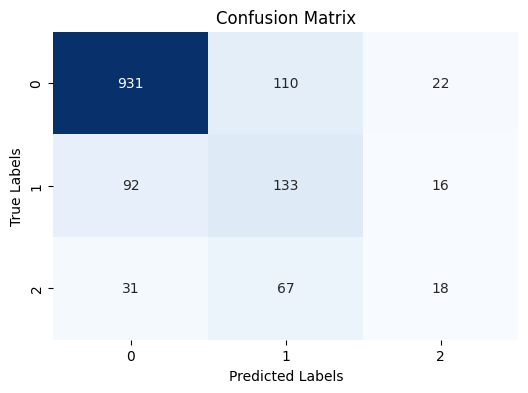


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 931/1063 (87.58%)
Class 1: Correct Predictions / Total True Samples = 133/241 (55.19%)
Class 2: Correct Predictions / Total True Samples = 18/116 (15.52%)

Precision-Recall Curves:


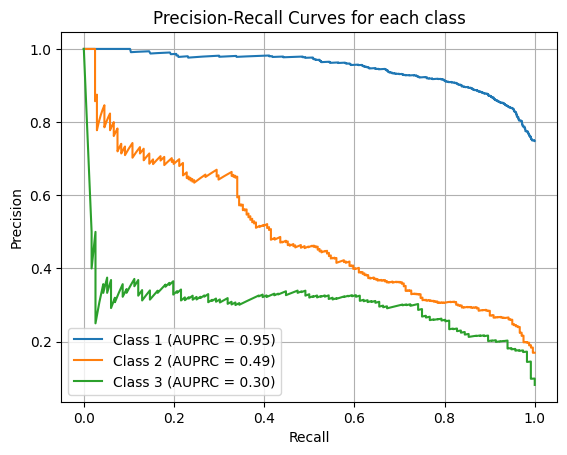


ROC Curves:


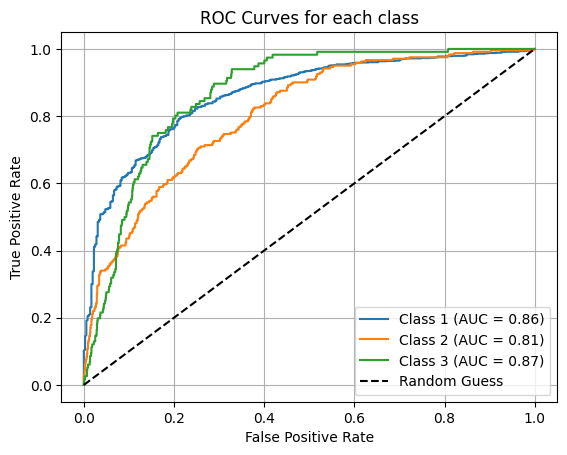


Mean F1 Score: 0.5239
Balanced Accuracy: 0.5276
Average AUPRC: 0.5812

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1063
           1       0.43      0.55      0.48       241
           2       0.32      0.16      0.21       116

    accuracy                           0.76      1420
   macro avg       0.54      0.53      0.52      1420
weighted avg       0.76      0.76      0.76      1420

Fold No: 3
Epoch [1/100], Loss: 1.0745, Accuracy: 0.4326
Validation Loss: 1.2236, Validation Accuracy: 0.3703
Epoch [2/100], Loss: 1.0594, Accuracy: 0.4727
Validation Loss: 0.9961, Validation Accuracy: 0.4353
Epoch [3/100], Loss: 1.0322, Accuracy: 0.5591
Validation Loss: 1.0828, Validation Accuracy: 0.4787
Epoch [4/100], Loss: 1.0019, Accuracy: 0.5970
Validation Loss: 0.9722, Validation Accuracy: 0.4912
Epoch [5/100], Loss: 0.9995, Accuracy: 0.6008
Validation Loss: 0.9096, Validation Accuracy: 0.4538
Epoch [6/100], Los

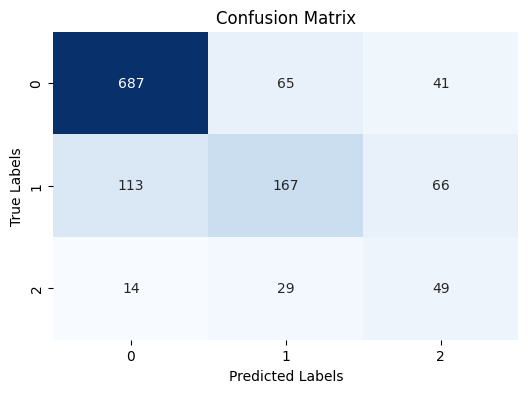


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 687/793 (86.63%)
Class 1: Correct Predictions / Total True Samples = 167/346 (48.27%)
Class 2: Correct Predictions / Total True Samples = 49/92 (53.26%)

Precision-Recall Curves:


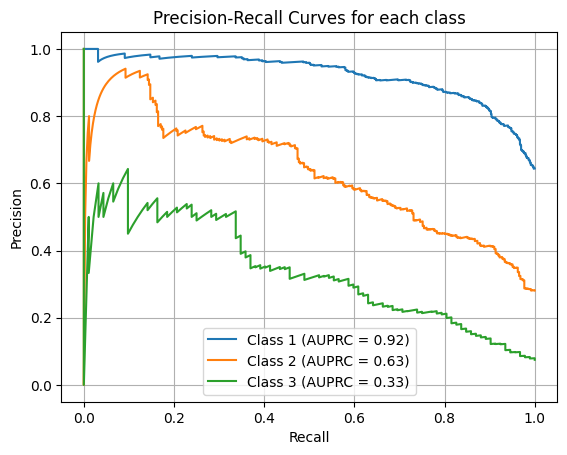


ROC Curves:


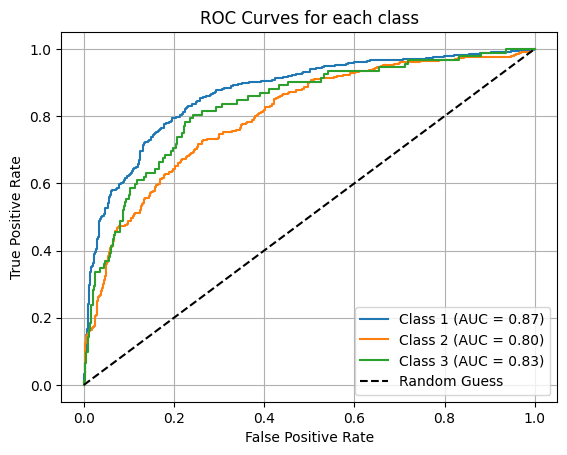


Mean F1 Score: 0.6001
Balanced Accuracy: 0.6272
Average AUPRC: 0.6291

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       793
           1       0.64      0.48      0.55       346
           2       0.31      0.53      0.40        92

    accuracy                           0.73      1231
   macro avg       0.60      0.63      0.60      1231
weighted avg       0.75      0.73      0.73      1231

Fold No: 4
Epoch [1/100], Loss: 1.0950, Accuracy: 0.3752
Validation Loss: 1.0438, Validation Accuracy: 0.5410
Epoch [2/100], Loss: 1.0740, Accuracy: 0.4681
Validation Loss: 1.0382, Validation Accuracy: 0.5167
Epoch [3/100], Loss: 1.0436, Accuracy: 0.5064
Validation Loss: 0.9758, Validation Accuracy: 0.4752
Epoch [4/100], Loss: 1.0354, Accuracy: 0.5209
Validation Loss: 1.0451, Validation Accuracy: 0.5239
Epoch [5/100], Loss: 1.0205, Accuracy: 0.5647
Validation Loss: 0.9999, Validation Accuracy: 0.5988
Epoch [6/100], Los

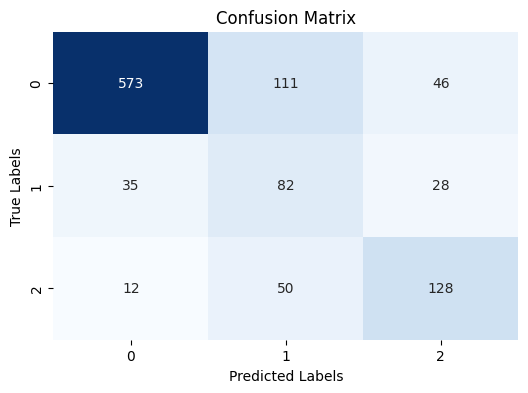


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 573/730 (78.49%)
Class 1: Correct Predictions / Total True Samples = 82/145 (56.55%)
Class 2: Correct Predictions / Total True Samples = 128/190 (67.37%)

Precision-Recall Curves:


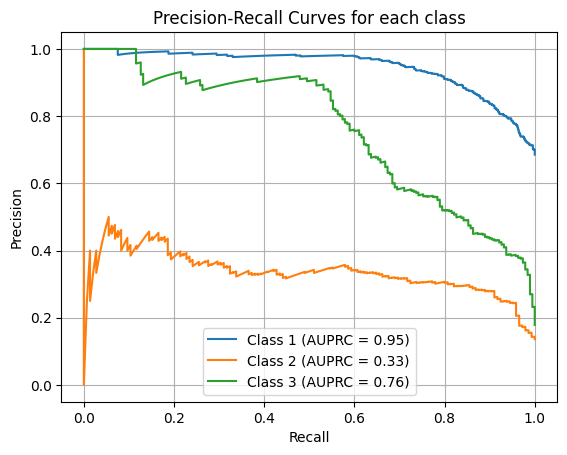


ROC Curves:


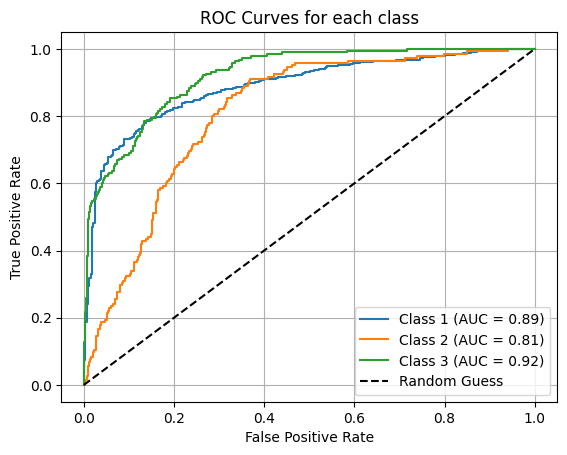


Mean F1 Score: 0.6415
Balanced Accuracy: 0.6747
Average AUPRC: 0.6799

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.78      0.85       730
           1       0.34      0.57      0.42       145
           2       0.63      0.67      0.65       190

    accuracy                           0.74      1065
   macro avg       0.63      0.67      0.64      1065
weighted avg       0.79      0.74      0.76      1065

Fold No: 5
Epoch [1/100], Loss: 1.0994, Accuracy: 0.3205
Validation Loss: 1.0918, Validation Accuracy: 0.3279
Epoch [2/100], Loss: 1.0789, Accuracy: 0.4209
Validation Loss: 1.0039, Validation Accuracy: 0.5165
Epoch [3/100], Loss: 1.0428, Accuracy: 0.5096
Validation Loss: 1.1109, Validation Accuracy: 0.4341
Epoch [4/100], Loss: 1.0429, Accuracy: 0.5064
Validation Loss: 0.9489, Validation Accuracy: 0.5922
Epoch [5/100], Loss: 1.0151, Accuracy: 0.5769
Validation Loss: 0.9382, Validation Accuracy: 0.6140
Epoch [6/100], Los

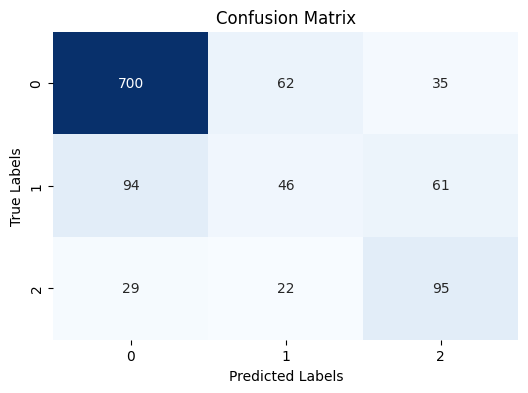


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 700/797 (87.83%)
Class 1: Correct Predictions / Total True Samples = 46/201 (22.89%)
Class 2: Correct Predictions / Total True Samples = 95/146 (65.07%)

Precision-Recall Curves:


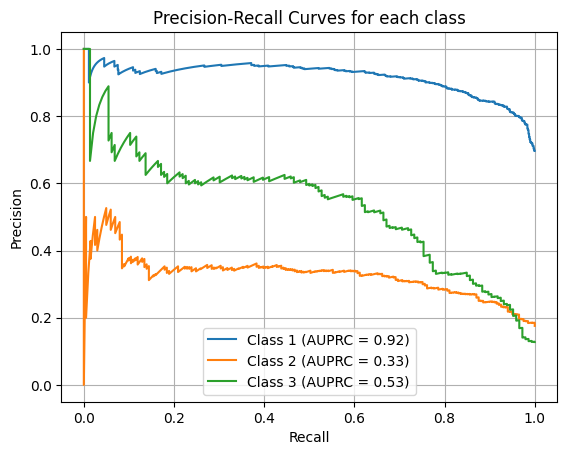


ROC Curves:


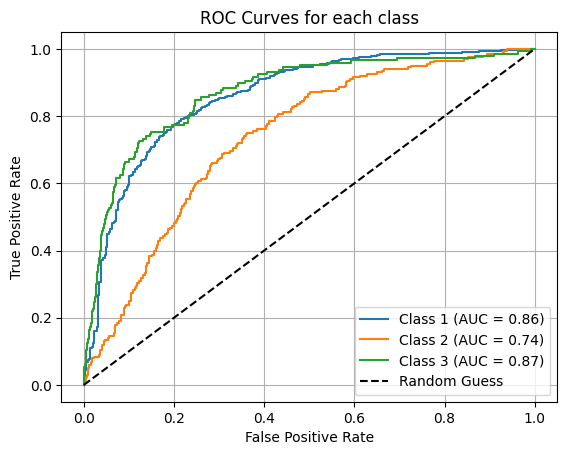


Mean F1 Score: 0.5686
Balanced Accuracy: 0.5859
Average AUPRC: 0.5906

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       797
           1       0.35      0.23      0.28       201
           2       0.50      0.65      0.56       146

    accuracy                           0.74      1144
   macro avg       0.57      0.59      0.57      1144
weighted avg       0.72      0.74      0.72      1144


RESULTS FOR PARAMETER SET 5
Accuracy for each fold: ['0.5930', '0.5276', '0.6272', '0.6747', '0.5859']
Average Accuracy: 0.6017
AUPRC for each fold: ['0.5359', '0.5812', '0.6291', '0.6799', '0.5906']
Average AUPRC: 0.6034
Best fold class-wise balanced accuracy: ['0.7850', '0.3795', '0.4848']


FINAL SUMMARY OF ALL 5 PARAMETER SETS

Parameter Set 1:
Parameters: {'hidden_size': 64, 'num_layers': 4, 'learning_rate': 0.0003457860039763819, 'weight_decay': 5.944172232271371e-06, 'batch_size': 32, 'dropout': 0.3, 'label_smo

In [10]:
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, auc

top_params = top_5_hyperparameters = [
    # trial 112, accuracy: 0.7099
    {'hidden_size': 64, 'num_layers': 4, 'learning_rate': 0.0003457860039763819, 'weight_decay': 5.944172232271371e-06, 'batch_size': 32, 'dropout': 0.3, 'label_smoothing': 0.3, 'factor': 1, 'optimizer_name': 'Adam'},  
    # trial 90, accuracy: 0.7020
    {'hidden_size': 256, 'num_layers': 4, 'learning_rate': 0.00046037658937661427, 'weight_decay': 8.389509863697752e-06, 'batch_size': 32, 'dropout': 0.3, 'label_smoothing': 0.3, 'factor': 1, 'optimizer_name': 'Adam'},  
    # trial 229, accuracy: 0.7086
    {'hidden_size': 256, 'num_layers': 4, 'learning_rate': 0.00020601678097967096, 'weight_decay': 1.4147278204236746e-05, 'batch_size': 32, 'dropout': 0.2, 'label_smoothing': 0.3, 'factor': 1, 'optimizer_name': 'Adam'},  
    # trial 174, accuracy: 0.6843
    {'hidden_size': 256, 'num_layers': 4, 'learning_rate': 0.00010881956338415986, 'weight_decay': 7.962304579713443e-06, 'batch_size': 32, 'dropout': 0.2, 'label_smoothing': 0.3, 'factor': 1, 'optimizer_name': 'Adam'},  
    # trial 242, accuracy: 0.6814
    {'hidden_size': 256, 'num_layers': 4, 'learning_rate': 0.0001667453140535747, 'weight_decay': 1.0022271626546467e-05, 'batch_size': 32, 'dropout': 0.2, 'label_smoothing': 0.3, 'factor': 1, 'optimizer_name': 'Adam'},  
]


# Fold indices and other configurations
num_folds = 5
fold_indices = np.random.permutation(np.arange(num_folds))
val_fold_indices = np.roll(fold_indices, 1)

# Model and training configurations
num_classes = 3
input_size = 224 * 3
epochs = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'



def calculate_class_wise_balanced_accuracy(y_true, y_pred, num_classes):
    """Calculate accuracy for each class using confusion matrix approach"""
    class_accuracies = []
    
    for i in range(num_classes):
        correct = np.sum((y_true == i) & (y_pred == i))
        total = np.sum((y_true == i) | (y_pred == i))
        class_accuracies.append(correct / total if total > 0 else 0.0)

    return class_accuracies

# Store results for all parameter sets
all_run_results = []

# Loop through all parameter sets
for param_idx, params in enumerate(top_params):
    print(f"\n{'='*80}")
    print(f"RUNNING PARAMETER SET {param_idx + 1}/5")
    print(f"{'='*80}")
    print(f"Parameters: {params}")
    print(f"{'='*80}\n")
    
    # Extract parameters
    hidden_size = params["hidden_size"]
    num_layers = params.get("num_layers", 1)
    dropout = params["dropout"]
    learning_rate = params['learning_rate']
    weight_decay = params['weight_decay']
    batch_size = params['batch_size']
    
    # Initialize lists for this parameter set
    fold_accuracies = []
    fold_auprcs = []
    fold_confusion_matrices = []
    fold_class_wise_accuracies = []
    test_folds_chosen = []
    val_folds_chosen = []

    # Training loop for cross-validation
    for fold_idx in range(num_folds):
        print(f'Fold No: {fold_idx + 1}')

        # Initialize model, loss, and optimizer
        fold_model = LstmAttention(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            num_classes=num_classes,
            dropout=dropout
        ).to(device)

        criterion = nn.CrossEntropyLoss(label_smoothing=0.3)
        optimizer = optim.Adam(fold_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

        # Split data into train, validation, and test sets
        test_fold = fold_indices[fold_idx]
        val_fold = val_fold_indices[fold_idx]
        train_folds = [fold for fold in fold_indices if fold != test_fold and fold != val_fold]

        train_data = np.concatenate([eeg_folds[j] for j in train_folds])
        train_labels = np.concatenate([labels_folds[j] for j in train_folds])
        train_data = train_data.reshape((train_data.shape[0], train_data.shape[1], train_data.shape[2]*train_data.shape[3]))

        test_folds_chosen.append(test_fold)
        val_folds_chosen.append(val_fold)

        early_stopping = EarlyStopping(patience=10)

        # Training loop
        for epoch in range(epochs):
            balanced_train_data, balanced_train_labels = data_balancer(train_data, train_labels, factor=1)

            train_dataset = TensorDataset(
                torch.tensor(balanced_train_data, dtype=torch.float32).to(device),
                torch.tensor(balanced_train_labels, dtype=torch.long).to(device)
            )
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

            fold_model.train()
            running_loss = 0.0
            all_preds = []
            all_labels = []

            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = fold_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / len(train_loader)
            epoch_acc = balanced_accuracy_score(all_labels, all_preds)
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

            # Validation loop
            val_data = eeg_folds[val_fold]
            val_data = val_data.reshape((val_data.shape[0], val_data.shape[1], val_data.shape[2]*val_data.shape[3]))
            val_labels = labels_folds[val_fold]
            val_dataset = TensorDataset(
                torch.tensor(val_data, dtype=torch.float32).to(device),
                torch.tensor(val_labels, dtype=torch.long).to(device)
            )
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            fold_model.eval()
            val_loss = 0.0
            val_preds = []
            val_labels_list = []

            with torch.no_grad():
                for val_inputs, val_labels_batch in val_loader:
                    val_outputs = fold_model(val_inputs)
                    loss = criterion(val_outputs, val_labels_batch)
                    val_loss += loss.item()

                    _, val_batch_preds = torch.max(val_outputs, 1)
                    val_preds.extend(val_batch_preds.cpu().numpy())
                    val_labels_list.extend(val_labels_batch.cpu().numpy())

            val_loss /= len(val_loader)
            val_acc = balanced_accuracy_score(val_labels_list, val_preds)
            print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

            early_stopping(val_loss, fold_model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        # Load the best model
        early_stopping.load_best_model(fold_model)

        # Test loop
        test_data = eeg_folds[test_fold]
        test_data = test_data.reshape((test_data.shape[0], test_data.shape[1], test_data.shape[2]*test_data.shape[3]))
        test_labels = labels_folds[test_fold]
        test_dataset = TensorDataset(
            torch.tensor(test_data, dtype=torch.float32).to(device),
            torch.tensor(test_labels, dtype=torch.long).to(device)
        )
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        fold_model.eval()
        test_probs = []
        test_preds = []
        test_labels_list = []

        with torch.no_grad():
            for test_inputs, test_labels_batch in test_loader:
                test_outputs = fold_model(test_inputs)
                probabilities = torch.softmax(test_outputs, dim=1)
                test_probs.extend(probabilities.cpu().numpy())
                _, preds = torch.max(probabilities, 1)
                test_preds.extend(preds.cpu().numpy())
                test_labels_list.extend(test_labels_batch.cpu().numpy())

        # Compute metrics
        test_acc = balanced_accuracy_score(test_labels_list, test_preds)
        fold_accuracies.append(test_acc)

        cm = confusion_matrix(test_labels_list, test_preds)
        fold_confusion_matrices.append(cm)

        # Calculate class-wise balanced accuracy
        class_wise_acc = calculate_class_wise_balanced_accuracy(np.array(test_labels_list), np.array(test_preds), num_classes)
        fold_class_wise_accuracies.append(class_wise_acc)

        test_labels_binarized = label_binarize(test_labels_list, classes=np.arange(num_classes))
        test_auprcs = []
        for class_idx in range(num_classes):
            precision, recall, _ = precision_recall_curve(test_labels_binarized[:, class_idx], np.array(test_probs)[:, class_idx])
            auprc = auc(recall, precision)
            test_auprcs.append(auprc)

        mean_test_auprc = np.mean(test_auprcs)
        fold_auprcs.append(mean_test_auprc)

        print(f'Test Fold {fold_idx + 1}, Mean AUPRC: {mean_test_auprc:.4f}, Balanced Accuracy: {test_acc:.4f}')
        print(f'Class-wise Balanced Accuracy: {[f"{acc:.4f}" for acc in class_wise_acc]}')

        # Use the plot_metrics function to visualize metrics
        plot_metrics(np.array(test_labels_list), np.array(test_probs), n_classes=num_classes)

    # Calculate best fold class-wise balanced accuracy
    fold_class_wise_accuracies = np.array(fold_class_wise_accuracies)
    best_fold_class_wise = np.max(fold_class_wise_accuracies, axis=0)

    # Final metrics across all folds for this parameter set
    average_auprc = np.mean(fold_auprcs)
    mean_accuracy = np.mean(fold_accuracies)
    
    print(f"\n{'='*60}")
    print(f"RESULTS FOR PARAMETER SET {param_idx + 1}")
    print(f"{'='*60}")
    print(f'Accuracy for each fold: {[f"{acc:.4f}" for acc in fold_accuracies]}')
    print(f'Average Accuracy: {mean_accuracy:.4f}')
    print(f'AUPRC for each fold: {[f"{auprc:.4f}" for auprc in fold_auprcs]}')
    print(f'Average AUPRC: {average_auprc:.4f}')
    print(f'Best fold class-wise balanced accuracy: {[f"{acc:.4f}" for acc in best_fold_class_wise]}')
    print(f"{'='*60}\n")
    
    # Store results for final summary
    run_result = {
        'param_set': param_idx + 1,
        'params': params,
        'fold_accuracies': fold_accuracies,
        'average_accuracy': mean_accuracy,
        'fold_auprcs': fold_auprcs,
        'average_auprc': average_auprc,
        'best_fold_class_wise_accuracy': best_fold_class_wise
    }
    all_run_results.append(run_result)
    

# Final summary of all runs
print(f"\n{'='*80}")
print(f"FINAL SUMMARY OF ALL 5 PARAMETER SETS")
print(f"{'='*80}")

for result in all_run_results:
    print(f"\nParameter Set {result['param_set']}:")
    print(f"Parameters: {result['params']}")
    print(f"Accuracy for each fold: {[f'{acc:.4f}' for acc in result['fold_accuracies']]}")
    print(f"Average Accuracy: {result['average_accuracy']:.4f}")
    print(f"AUPRC for each fold: {[f'{auprc:.4f}' for auprc in result['fold_auprcs']]}")
    print(f"Average AUPRC: {result['average_auprc']:.4f}")
    print(f"Best fold class-wise balanced accuracy: {[f'{acc:.4f}' for acc in result['best_fold_class_wise_accuracy']]}")
    print("-" * 60)

print(f"{'='*80}")
